______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [1]:
pip install 'dtreeviz'

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [237]:
#Importación de librerías
import dtreeviz.trees as dtreeviz

import numpy as np
import cmath as math

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pandas as pd

import seaborn as sns

import scipy as sc

import sklearn as sk
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score, f1_score

#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
#from google.colab import drive
#drive.mount('/content/drive')
#properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')
properati=pd.read_csv('properati_argentina_2021.csv')

#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**


A continuación se realizará un análisis general de cada una de las variables presentes en el dataframe.

In [3]:
df = properati.copy()
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [4]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


### Preparación de los datasets

---

Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [5]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])
df.drop("operation", inplace=True, axis=1)
df.drop("property_currency", inplace=True, axis=1)
df.drop("property_title", inplace=True, axis=1)
train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price']

### Descripción de Campos

---

`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

---

Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [6]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

,latitud,longitud,place_l5,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
mean,-34.591481,-58.449795,NaN,NaN,2.822799,2.014629,109.092970,87.931932,226238.207185
25%,-34.615975,-58.466522,NaN,NaN,2.000000,1.000000,45.000000,40.000000,95000.000000
75%,-34.577413,-58.408862,NaN,NaN,4.000000,3.000000,105.000000,88.000000,237000.000000
std,0.181719,0.292630,NaN,NaN,1.426148,1.129767,980.401976,990.927129,318603.483648
median,-34.595790,-58.439000,NaN,NaN,3.000000,2.000000,65.000000,58.000000,143900.000000


### Variables Cualitativas: Cantidades y Frecuencias

---

Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [7]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


<AxesSubplot: >

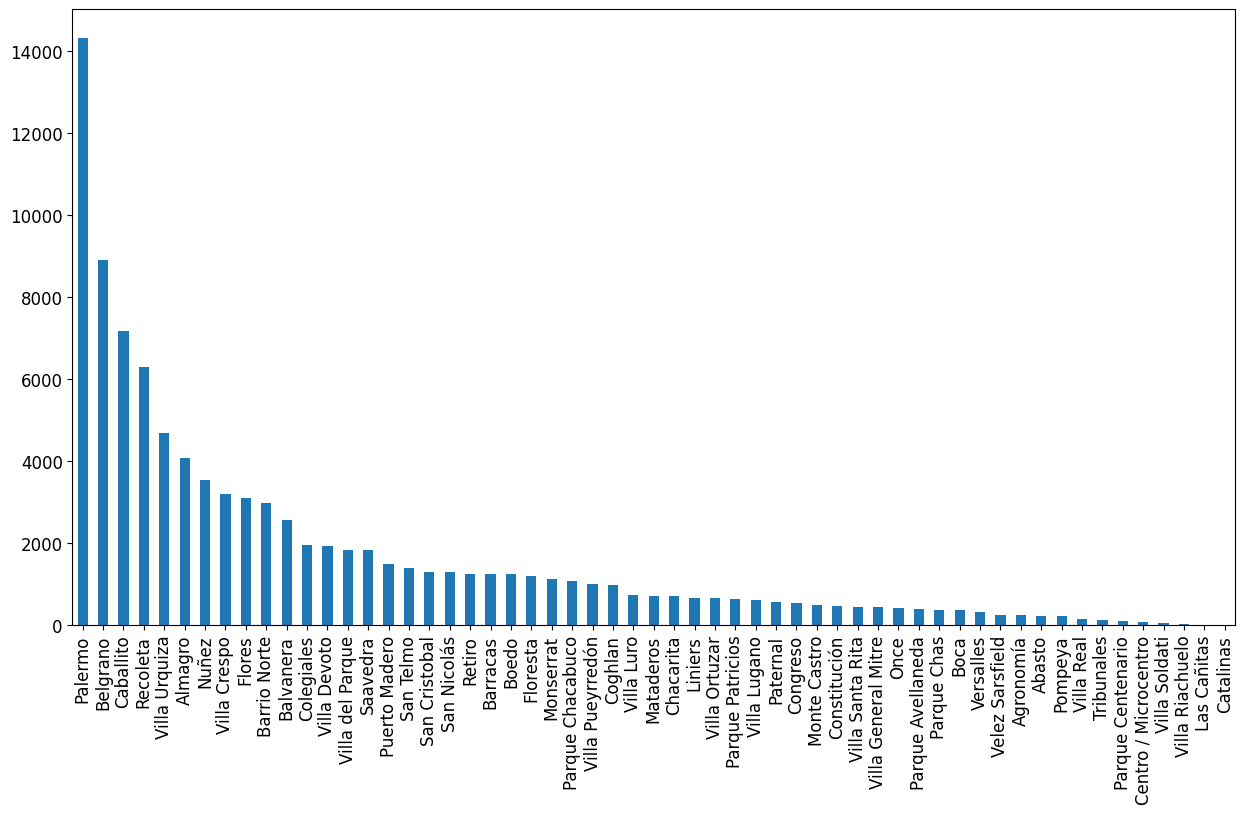

In [8]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [9]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


<AxesSubplot: >

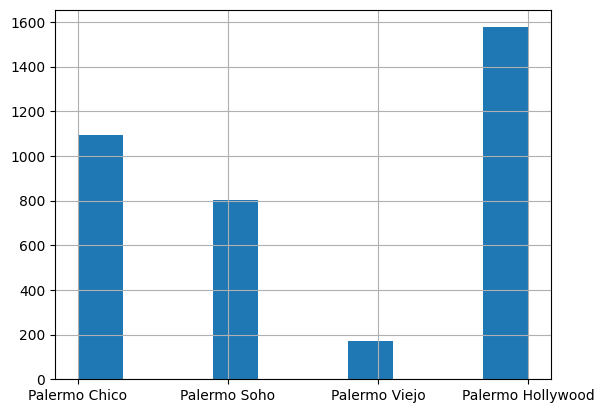

In [10]:
df['place_l4'].hist()

<AxesSubplot: >

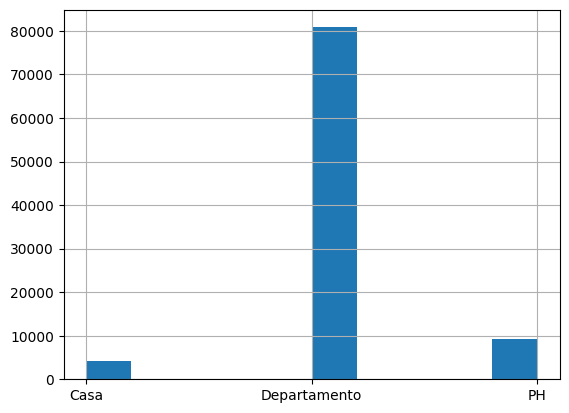

In [11]:
df['property_type'].hist()

In [12]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

---

Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

---



#### Densidad de la variable `latitud`

<AxesSubplot: xlabel='latitud', ylabel='Density'>

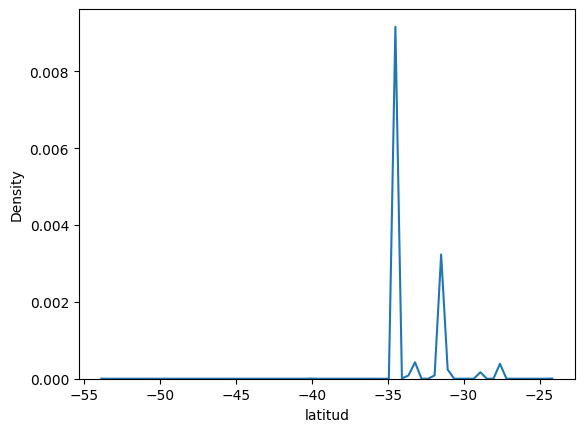

In [13]:
sns.kdeplot(data=df.latitud, gridsize=70)

#### Densidad de la variable `longitud`

<AxesSubplot: xlabel='longitud', ylabel='Density'>

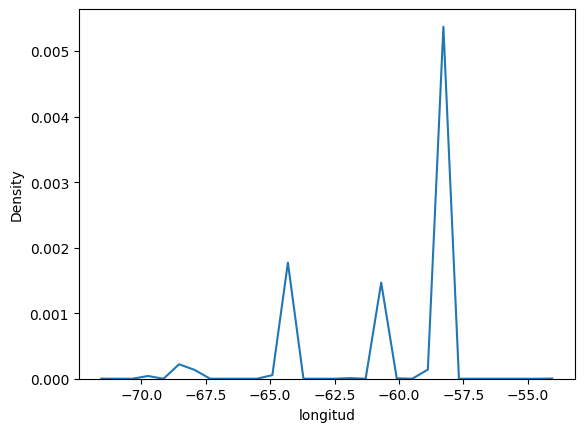

In [14]:
sns.kdeplot(data=df.longitud, gridsize=30)


#### Densidad de la variable `property_price`

<AxesSubplot: xlabel='property_price', ylabel='Density'>

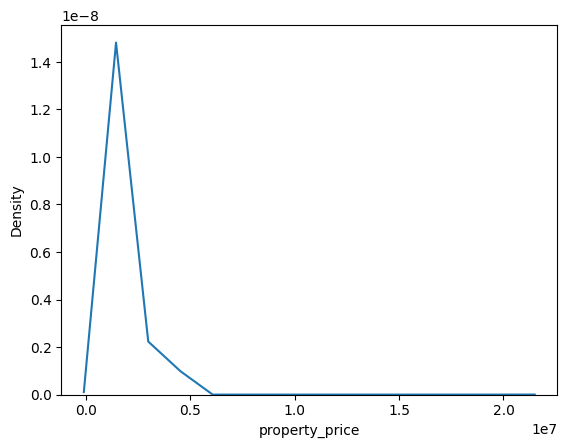

In [15]:
sns.kdeplot(data=df.property_price, gridsize=15)


#### Densidad de la variable `property_rooms`

<AxesSubplot: xlabel='property_rooms', ylabel='count'>

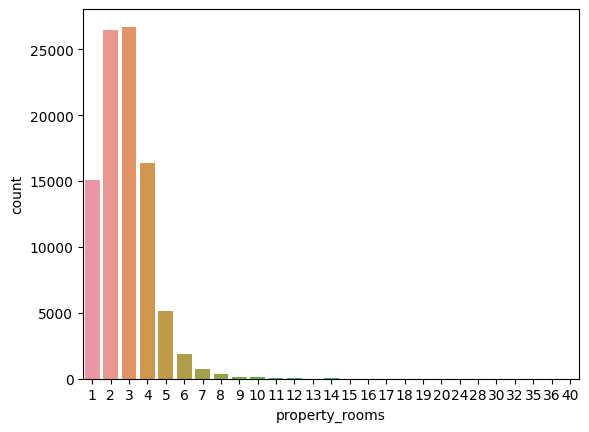

In [16]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

#### Densidad de la variable `property_surface_covered`

<AxesSubplot: xlabel='property_surface_covered', ylabel='Density'>

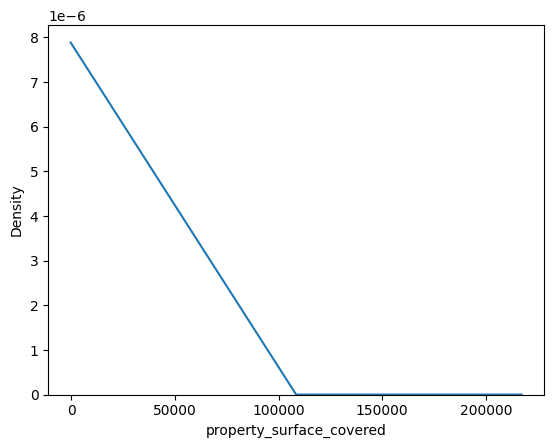

In [17]:
sns.kdeplot(data=df.property_surface_covered, gridsize=3)


### Análisis de las Correlaciones existentes entre las Variables

---

In [18]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [19]:
columns = df.columns.tolist()
df_pariplot = df[columns].copy()
# graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

## **1b. Datos Faltantes**

A continuación se realizara un análisis sobre los datos faltantes del dataframe.

Creamos una copia del dataset hasta el momento para comparar más adelante.

In [20]:
df_copy = df.copy()

### Análisis a Nivel Columna

---



Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

<AxesSubplot: >

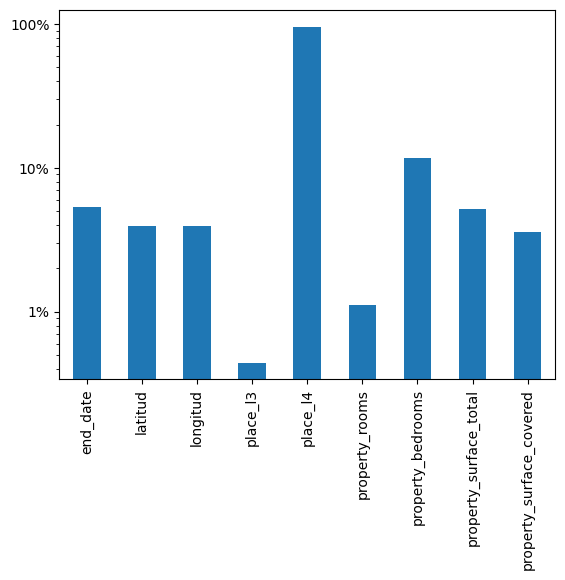

In [21]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

---



Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

<AxesSubplot: >

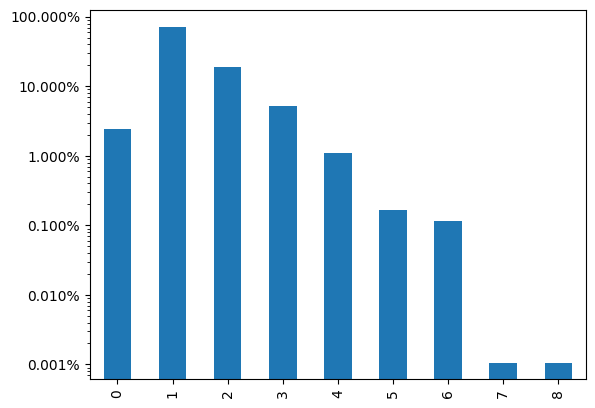

In [22]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

---



A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [23]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

<AxesSubplot: >

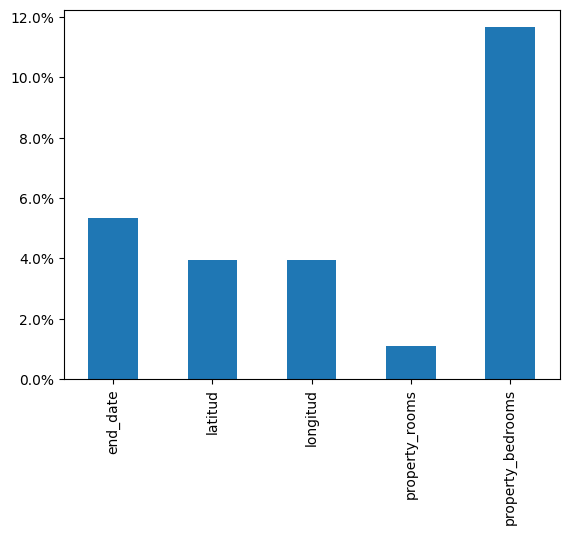

In [24]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

Reemplazamos la cantidad de habitaciones no definidos por la media calculada filtrando por cantidad total de dormitorios.

In [25]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)

Para eliminar los últimos valores nulos en las columnas de habitaciones, lo completamos con una regresión en funcion de la superficie cubierta

In [26]:
from sklearn.linear_model import LinearRegression
df_train = df.loc[df['property_rooms'].notna()]
reg = LinearRegression().fit(np.array(df_train['property_surface_covered']).reshape(-1, 1), df_train['property_rooms'])

In [27]:
df_topredict = df.loc[df['property_rooms'].isna()]['property_surface_covered']
df['property_rooms'] = df.apply(lambda x: round(reg.predict([[x.property_surface_covered]])[0]) if pd.isna(x.property_rooms) else x.property_rooms, axis=1)

Luego reemplazamos la cantidad total de dormitorios no definidas por la media calculada filtrando por cantidad de habitaciones.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

<AxesSubplot: >

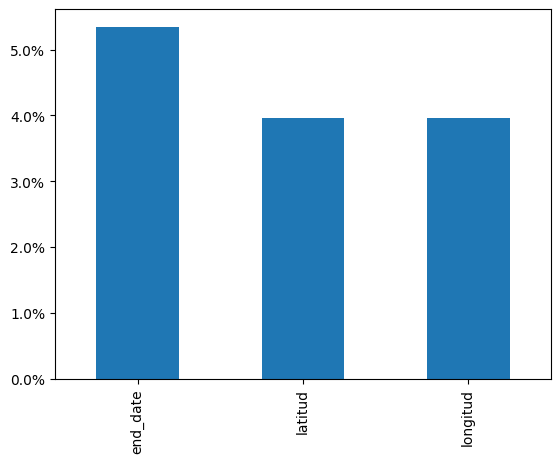

In [28]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[df['property_rooms'] == i].property_bedrooms.median()
    if pd.isna(median):
        median = df.loc[df['property_rooms'] == i]['property_rooms'].iloc[0]
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)

# df['property_bedrooms'] = df['property_bedrooms'].replace(np.nan, 0)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

In [29]:
df["property_bedrooms"].isnull().sum()
df.loc[df["property_bedrooms"].isnull() == True]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price


In [30]:
df["property_bedrooms"].isna().sum()

0

<AxesSubplot: ylabel='Density'>

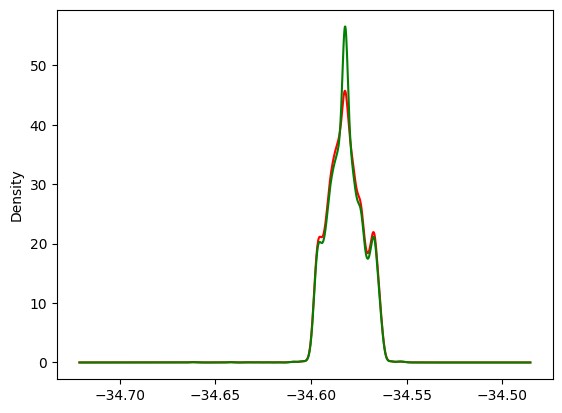

In [31]:
df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    lat_median = df.loc[(df["place_l4"] == barrio) & (df['latitud'].notna()) ].latitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"] = df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"].fillna(lat_median)

df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "green")

<AxesSubplot: ylabel='Density'>

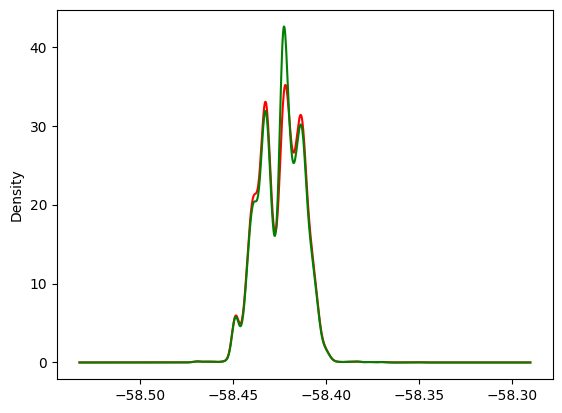

In [32]:
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    long_median = df.loc[(df["place_l4"] == barrio) & (df['longitud'].notna())].longitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"] = df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"].fillna(long_median)
    
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "green")

<AxesSubplot: >

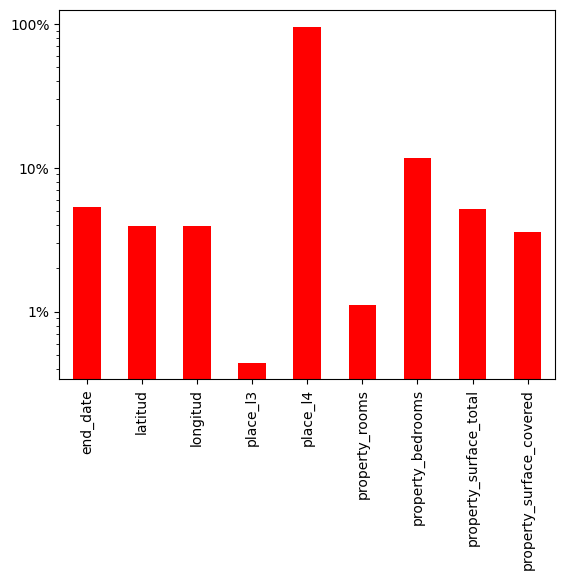

In [33]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df_copy.isnull().sum() * 100 / len(df_copy)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="red", zorder=0)

<AxesSubplot: >

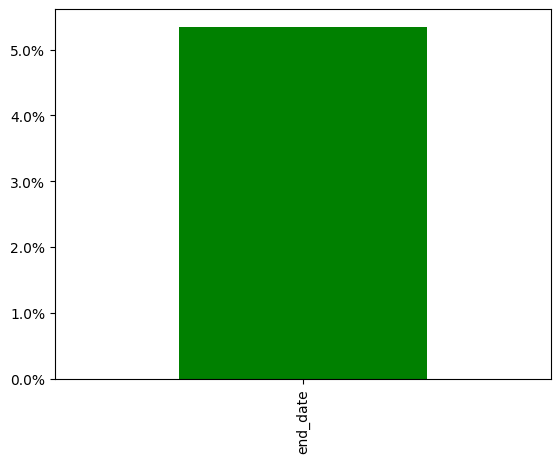

In [34]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="green", zorder=1)

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe. En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).

### Outliers univariados

---

Para el análisis de outliers de tipo univariados estaremos utilizando tanto el método de Box Plot como los métodos de Z-Score y Z-Score Modificado.

Mientras que el primero nos brindará información respecto de los topes superiores e inferiores de los cuartiles Q3 y Q1 respectivamente, los gráficos de Z-Score y Z-Score modificado nos permitirán visualizar de forma eficiente cómo se distribuye la masa de observaciones respecto de la media, y -por tanto- poder determinar de forma más precisa cuáles son los valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Property rooms

##### Box plot

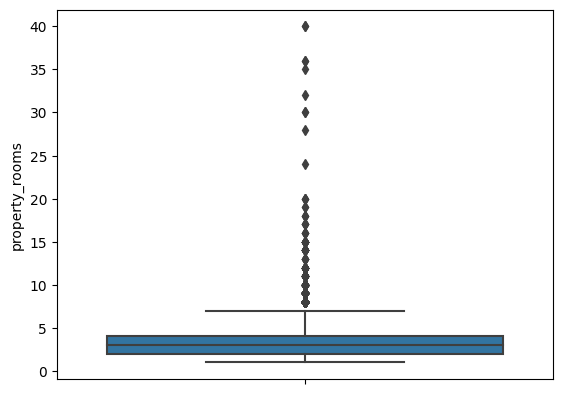

In [35]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [36]:
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


##### Z-Score

In [37]:
media_rooms=np.mean(df.property_rooms)
std_rooms=np.std(df.property_rooms)
df['z_rooms']=(df.property_rooms - media_rooms)/std_rooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [38]:
df[df['z_rooms']>3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,10.0,10.0,394.0,244.0,500000.0,4.985757
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Departamento,9.0,4.0,390.0,340.0,1200000.0,4.290082
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407


In [39]:
df[df['z_rooms']<-3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms


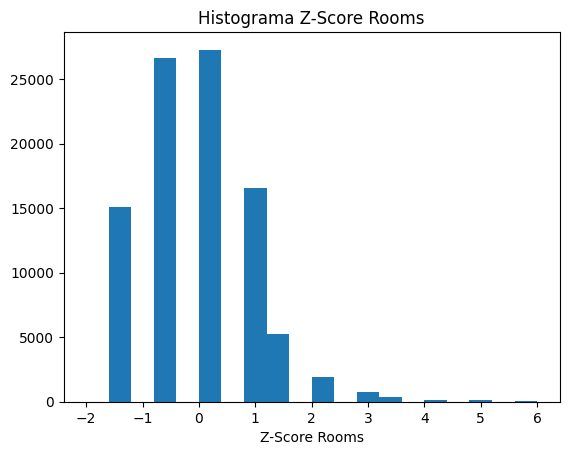

In [40]:
plt.hist(df.z_rooms, bins=20, range=(-2,6))
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Z-Score Modificado

In [41]:
mediana_room=np.nanmedian(df.property_rooms)

MAD=np.nanmedian(np.absolute(df.property_rooms-mediana_room))

df['zm_rooms']=(df.property_rooms - mediana_room)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [42]:
df[(df['zm_rooms']>3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,10.0,10.0,394.0,244.0,500000.0,4.985757,4.7215
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Departamento,9.0,4.0,390.0,340.0,1200000.0,4.290082,4.0470
1769,g1hq2MUtnOPGU2VYSr2BWw==,2021-12-17,2022-01-27,2021-12-17,-34.623581,-58.484051,Capital Federal,Floresta,Floresta,Casa,10.0,6.0,240.0,240.0,320000.0,4.985757,4.7215
1932,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,NaT,2021-12-17,-34.637026,-58.426283,Capital Federal,Parque Chacabuco,Parque Chacabuco,Casa,40.0,3.0,217000.0,217000.0,250000.0,25.856003,24.9565
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,PH,15.0,15.0,355.0,215.0,220000.0,8.464131,8.0940


In [43]:
df[(df['zm_rooms']<-3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms


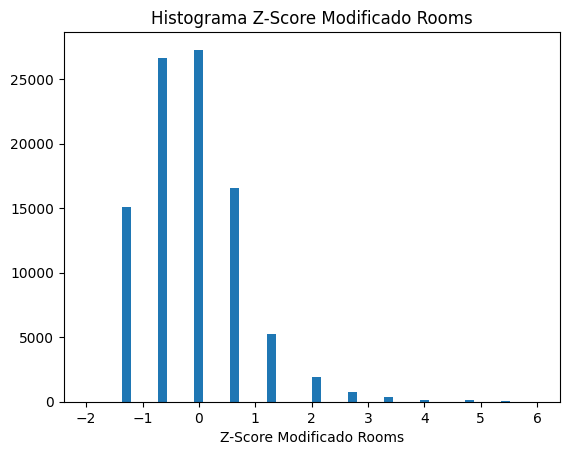

In [44]:
plt.hist(df.zm_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('Z-Score Modificado Rooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones que superan el límite superior del tercer cuartil, podríamos decir que los outliers en cuestión son del tipo colectivo.

#### Property bedrooms

 ##### Box plot


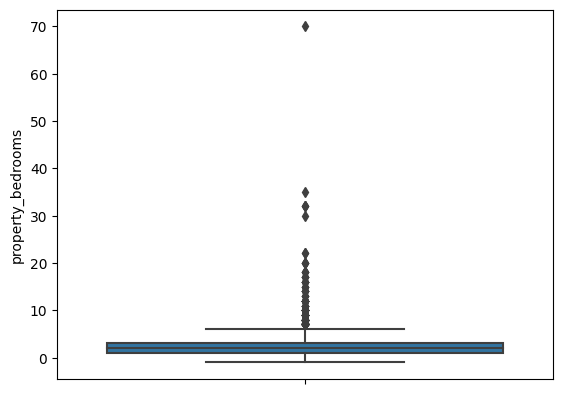

In [45]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [46]:
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


##### Z-Score

In [47]:
media_bedrooms=np.mean(df.property_bedrooms)
std_bedrooms=np.std(df.property_bedrooms)
df['z_bedrooms']=(df.property_bedrooms - media_bedrooms)/std_bedrooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [48]:
df[df['z_bedrooms']>3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.63373,-58.424729,Capital Federal,Boedo,Boedo,Casa,10.0,10.0,394.0,244.0,500000.0,4.985757,4.7215,7.217372
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.62075,-58.502759,Capital Federal,Villa Luro,Villa Luro,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407,3.3725,3.647266
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.62075,-58.502759,Capital Federal,Monte Castro,Monte Castro,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407,3.3725,3.647266
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.62075,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407,3.3725,3.647266
1363,rfG2Nb7079oZOP8wAKuwXA==,2021-09-09,2022-03-09,2021-09-09,-34.62075,-58.502759,Capital Federal,Villa Santa Rita,Villa Santa Rita,Casa,8.0,6.0,201.0,201.0,345000.0,3.594407,3.3725,3.647266


In [49]:
df[df['z_bedrooms']<-3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms


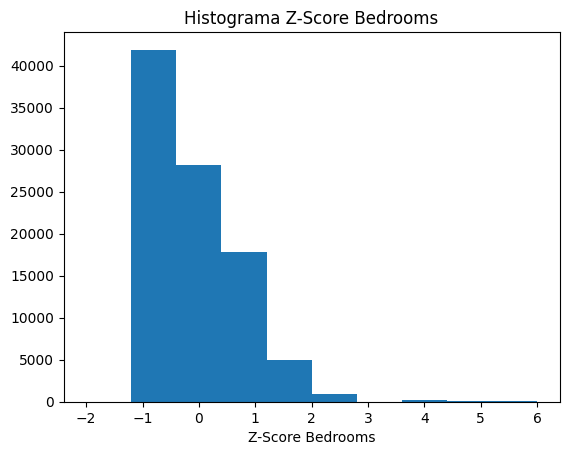

In [50]:
plt.hist(df.z_bedrooms, bins=10, range=(-2,6))
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Z-Score Modificado

In [51]:
mediana_bedroom=np.nanmedian(df.property_bedrooms)
MAD=np.nanmedian(np.absolute(df.property_bedrooms-mediana_bedroom))

df['zm_bedrooms']=(df.property_bedrooms - mediana_bedroom)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [52]:
df[(df['zm_bedrooms']>3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,10.0,10.0,394.0,244.0,500000.0,4.985757,4.7215,7.217372,5.3960
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,PH,15.0,15.0,355.0,215.0,220000.0,8.464131,8.0940,11.680003,8.7685
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,2021-10-29,-34.577180,-58.451264,Capital Federal,Colegiales,Colegiales,Departamento,6.0,8.0,424.0,324.0,660000.0,2.203058,2.0235,5.432319,4.0470
6920,7zvivHSapxLYLTcr6PsxAQ==,2021-02-09,NaT,2021-02-09,-34.620995,-58.374707,Capital Federal,San Telmo,San Telmo,Casa,10.0,9.0,511.0,380.0,920000.0,4.985757,4.7215,6.324845,4.7215
6922,TE83wpYe7pIeb5E3T7UxuA==,2021-02-09,2021-02-10,2021-02-09,-34.623819,-58.371153,Capital Federal,San Telmo,San Telmo,Casa,11.0,10.0,750.0,750.0,1500000.0,5.681432,5.3960,7.217372,5.3960


In [53]:
df[(df['zm_bedrooms']<-3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


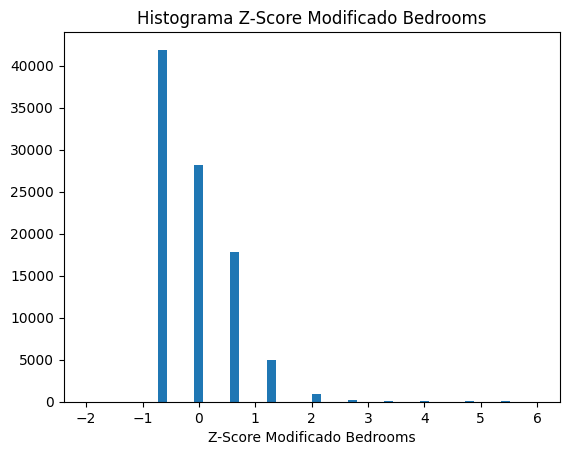

In [54]:
plt.hist(df.zm_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('Z-Score Modificado Bedrooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la singular por encima del resto de las observaciones).

#### Property price

##### Box plot

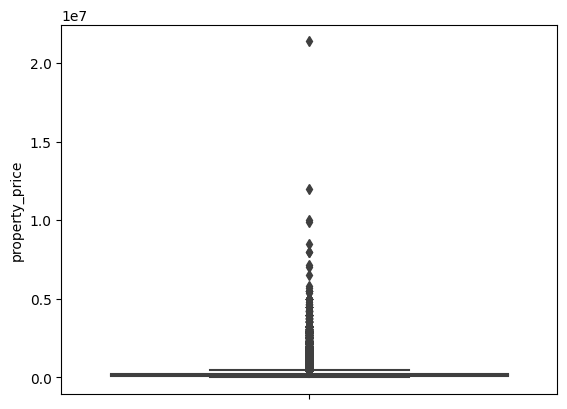

In [55]:
sns.boxplot(y=df.property_price)
plt.show()

In [56]:
Q1_property_price=df.describe().get("property_price").get("25%")
Q3_property_price=df.describe().get("property_price").get("75%")

print("El valor de Q1 es:", Q1_property_price)
print("El valor de Q3 es:", Q3_property_price)

IQR_property_price=Q3_property_price-Q1_property_price

out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 95000.0
El valor de Q3 es: 237000.0
El limite inferior del Q1 es: -118000.0
El limite superior del Q3 es: 450000.0


##### Z-Score

In [57]:
media_price=np.mean(df.property_price)
std_price=np.std(df.property_price)
df['z_price']=(df.property_price - media_price)/std_price

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [58]:
df[df['z_price']>3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,5.0,4.0,400.0,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,5.0,4.0,400.0,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Departamento,4.0,3.0,282.0,256.0,2250000.0,0.811708,0.6745,0.969687,0.6745,6.352010
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Departamento,5.0,4.0,304.0,294.0,1200000.0,1.507383,1.3490,1.862213,1.3490,3.056360
629,1Q/fC60k0cGKYTu6hUqf1g==,2021-09-09,2021-09-11,2021-09-09,-34.566536,-58.448246,Capital Federal,Belgrano,Belgrano,Departamento,4.0,3.0,214.0,196.0,1200000.0,0.811708,0.6745,0.969687,0.6745,3.056360


In [59]:
df[df['z_price']<-3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price


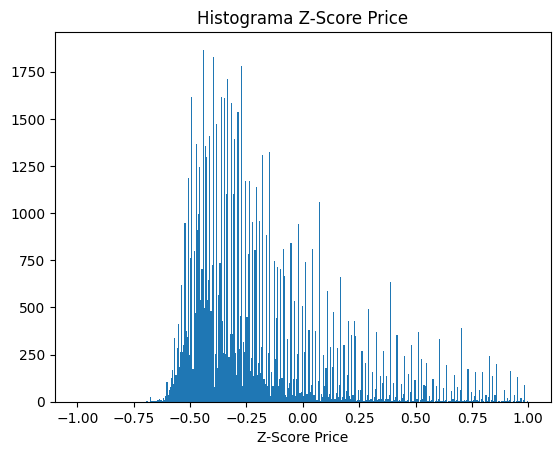

In [60]:
plt.hist(df.z_price, bins=400, range=(-1,1))
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.show()

##### Z-Score Modificado

In [61]:
mediana_price=np.nanmedian(df.property_price)
MAD=np.nanmedian(np.absolute(df.property_price-mediana_price))

df['zm_price']=(df.property_price - mediana_price)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [62]:
df[(df['zm_price']>3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,...,10.0,394.0,244.0,500000.0,4.985757,4.7215,7.217372,5.3960,0.859260,4.141197
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,4.0,400.0,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,4.0,400.0,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Departamento,...,3.0,282.0,256.0,2250000.0,0.811708,0.6745,0.969687,0.6745,6.352010,24.492491
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Departamento,...,4.0,304.0,294.0,1200000.0,1.507383,1.3490,1.862213,1.3490,3.056360,12.281715


In [63]:
df[(df['zm_price']<-3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price


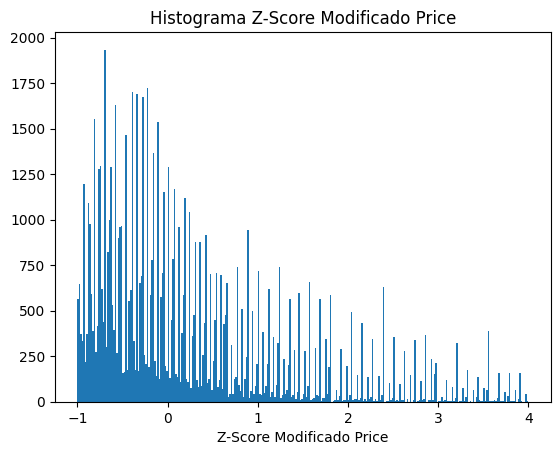

In [64]:
plt.hist(df.zm_price, bins=300, range=(-1,4))
plt.title('Histograma Z-Score Modificado Price')
plt.xlabel('Z-Score Modificado Price')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface covered

##### Box plot

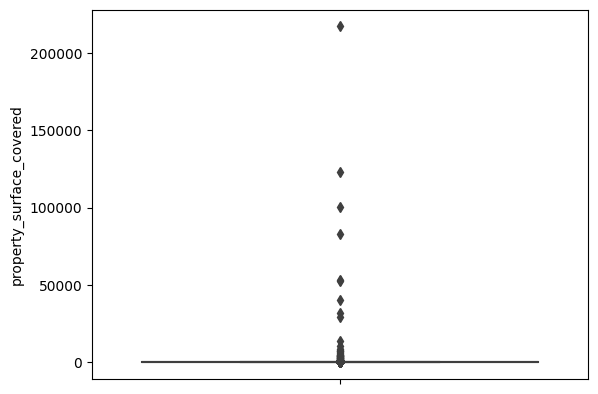

In [65]:
sns.boxplot(y=df.property_surface_covered)
plt.show()

In [66]:
Q1_property_surface_covered=df.describe().get("property_surface_covered").get("25%")
Q3_property_surface_covered=df.describe().get("property_surface_covered").get("75%")

print("El valor de Q1 es:", Q1_property_surface_covered)
print("El valor de Q3 es:", Q3_property_surface_covered)

IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 40.0
El valor de Q3 es: 89.0
El limite inferior del Q1 es: -33.5
El limite superior del Q3 es: 162.5


##### Z-Score

In [67]:
media_surface_covered=np.mean(df.property_surface_covered)
std_surface_covered=np.std(df.property_surface_covered)
df['z_surface_covered']=(df.property_surface_covered - media_surface_covered)/std_surface_covered

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [68]:
df[df['z_surface_covered']>3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered
1140,ddV7Ll5c1H+Rmqqovc+uFg==,2021-09-09,2022-01-27,2021-09-09,-34.605781,-58.376705,Capital Federal,San Nicolás,San Nicolás,Departamento,...,10500.0,10500.0,9900000.0,1.507383,1.3490,1.862213,1.3490,30.363174,113.456715,10.695485
1932,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,NaT,2021-12-17,-34.637026,-58.426283,Capital Federal,Parque Chacabuco,Parque Chacabuco,Casa,...,217000.0,217000.0,250000.0,25.856003,24.9565,0.969687,0.6745,0.074581,1.233870,222.821967
30359,rpeGyTLDvloNDFf/CSF6Aw==,2021-10-15,2022-01-27,2021-10-15,-34.620995,-58.374707,Capital Federal,San Telmo,San Telmo,Departamento,...,48.0,4435.0,93500.0,-0.579642,-0.6745,-0.815366,-0.6745,-0.416627,-0.586117,4.465232
72316,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,2021-05-29,-34.578917,-58.429373,Capital Federal,Palermo,Palermo,Departamento,...,61130.0,53030.0,225000.0,-0.579642,-0.6745,-0.815366,-0.6745,-0.003886,0.943137,54.384295
72521,csbBJk04jQXgGZLXTj5WAg==,2021-05-29,2021-06-13,2021-05-29,-34.600113,-58.403649,Capital Federal,Balvanera,Balvanera,Departamento,...,33800.0,31670.0,66000.0,-0.579642,-0.6745,-0.815366,-0.6745,-0.502942,-0.905923,32.442301


In [69]:
df[df['z_surface_covered']<-3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered


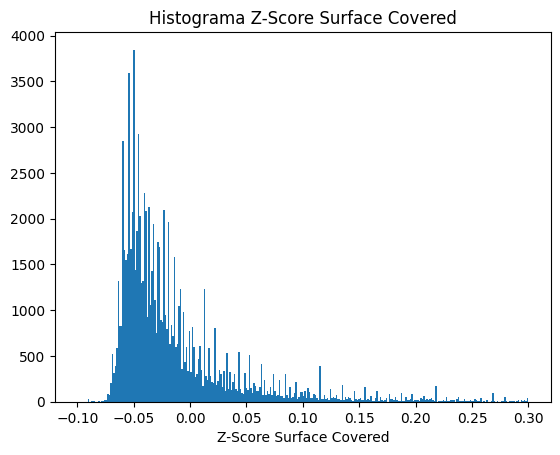

In [70]:
plt.hist(df.z_surface_covered, bins=300, range=(-0.1,0.3))
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Z-Score Modificado

In [71]:
mediana_surface_covered=np.nanmedian(df.property_surface_covered)
MAD=np.nanmedian(np.absolute(df.property_surface_covered-mediana_surface_covered))

df['zm_surface_covered']=(df.property_surface_covered - mediana_surface_covered)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [72]:
df[(df['zm_surface_covered']>3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,...,244.0,500000.0,4.985757,4.7215,7.217372,5.3960,0.859260,4.141197,0.160041,6.27285
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680,0.320291,11.53395
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,400.0,2700000.0,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680,0.320291,11.53395
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Departamento,...,256.0,2250000.0,0.811708,0.6745,0.969687,0.6745,6.352010,24.492491,0.172368,6.67755
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Departamento,...,294.0,1200000.0,1.507383,1.3490,1.862213,1.3490,3.056360,12.281715,0.211403,7.95910


In [73]:
df[(df['zm_surface_covered']<-3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered


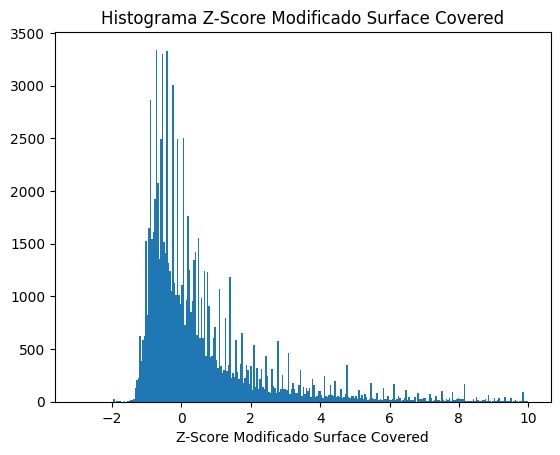

In [74]:
plt.hist(df.zm_surface_covered, bins=300, range=(-3,10))
plt.title('Histograma Z-Score Modificado Surface Covered')
plt.xlabel('Z-Score Modificado Surface Covered')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface total

##### Box plot

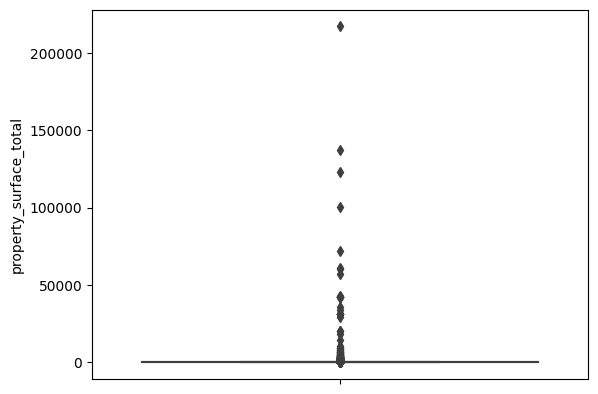

In [75]:
sns.boxplot(y=df.property_surface_total)
plt.show()

In [76]:
Q1_property_surface_total=df.describe().get("property_surface_total").get("25%")
Q3_property_surface_total=df.describe().get("property_surface_total").get("75%")

print("El valor de Q1 es:", Q1_property_surface_total)
print("El valor de Q3 es:", Q3_property_surface_total)

IQR_property_surface_total=Q3_property_surface_total-Q1_property_surface_total

out_inf=Q1_property_surface_total-1.5*IQR_property_surface_total
out_sup=Q3_property_surface_total+1.5*IQR_property_surface_total
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 45.0
El valor de Q3 es: 104.0
El limite inferior del Q1 es: -43.5
El limite superior del Q3 es: 192.5


##### Z-Score

In [77]:
media_surface_total=np.mean(df.property_surface_total)
std_surface_total=np.std(df.property_surface_total)
df['z_surface_total']=(df.property_surface_total - media_surface_total)/std_surface_total

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [78]:
df[df['z_surface_total']>3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total
1140,ddV7Ll5c1H+Rmqqovc+uFg==,2021-09-09,2022-01-27,2021-09-09,-34.605781,-58.376705,Capital Federal,San Nicolás,San Nicolás,Departamento,...,9900000.0,1.507383,1.3490,1.862213,1.3490,30.363174,113.456715,10.695485,352.156450,8.745611
1932,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,NaT,2021-12-17,-34.637026,-58.426283,Capital Federal,Parque Chacabuco,Parque Chacabuco,Casa,...,250000.0,25.856003,24.9565,0.969687,0.6745,0.074581,1.233870,222.821967,7316.368950,182.568661
33017,UzV402bMqMRezkA/xEyQ1w==,2021-02-08,NaT,2021-02-08,-34.634196,-58.465152,Capital Federal,Flores,Flores,Departamento,...,58552.0,-1.275317,-1.3490,-0.815366,-0.6745,-0.526319,-0.992538,-0.058763,-0.910575,3.634455
34123,Kr2fYXhFuQz9vuxKD2btYw==,2021-02-08,2021-05-01,2021-02-08,-34.557903,-58.452293,Capital Federal,Belgrano,Belgrano,Departamento,...,418000.0,0.811708,0.6745,0.969687,0.6745,0.601885,3.187594,0.021362,1.719975,4.115941
72316,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,2021-05-29,-34.578917,-58.429373,Capital Federal,Palermo,Palermo,Departamento,...,225000.0,-0.579642,-0.6745,-0.815366,-0.6745,-0.003886,0.943137,54.384295,1786.480700,51.363824


In [79]:
df[df['z_surface_total']<-3].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total


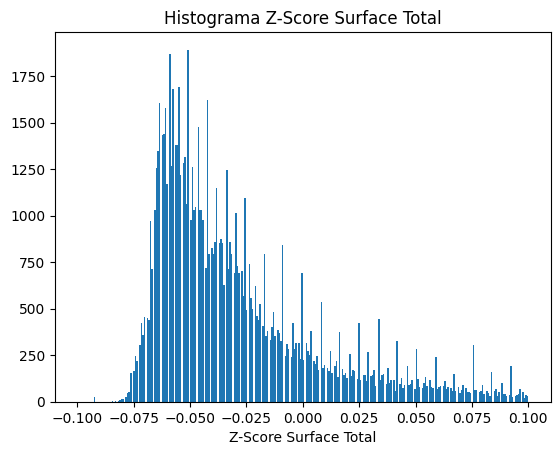

In [80]:
plt.hist(df.z_surface_total, bins=300, range=(-0.1,0.1))
plt.title('Histograma Z-Score Surface Total')
plt.xlabel('Z-Score Surface Total')
plt.show()

##### Z-Score Modificado

In [81]:
mediana_surface_total=np.nanmedian(df.property_surface_total)
MAD=np.nanmedian(np.absolute(df.property_surface_total-mediana_surface_total))

df['zm_surface_total']=(df.property_surface_total - mediana_surface_total)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [82]:
df[(df['zm_surface_total']>3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Casa,...,4.985757,4.7215,7.217372,5.3960,0.859260,4.141197,0.160041,6.27285,0.238803,8.87642
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680,0.320291,11.53395,0.243854,9.03830
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Departamento,...,1.507383,1.3490,1.862213,1.3490,7.764431,29.725680,0.320291,11.53395,0.243854,9.03830
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Departamento,...,0.811708,0.6745,0.969687,0.6745,6.352010,24.492491,0.172368,6.67755,0.144526,5.85466
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Departamento,...,1.507383,1.3490,1.862213,1.3490,3.056360,12.281715,0.211403,7.95910,0.163045,6.44822


In [83]:
df[(df['zm_surface_total']<-3.5)].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total


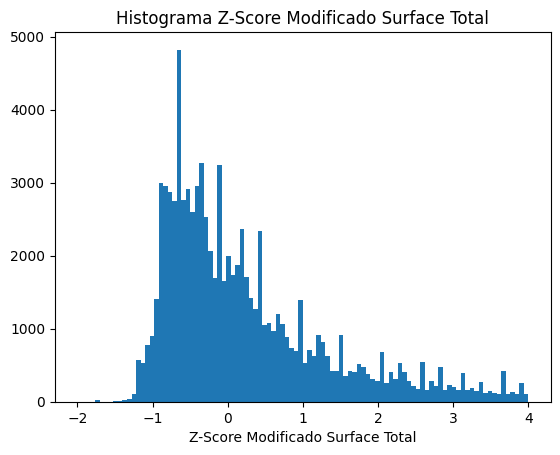

In [84]:
plt.hist(df.zm_surface_total, bins=100, range=(-2,4))
plt.title('Histograma Z-Score Modificado Surface Total')
plt.xlabel('Z-Score Modificado Surface Total')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

### Outliers multivariados

---

Para el análisis de outliers de tipo multivariados estaremos utilizando el método de Mahalanobis el cual nos brinda información respecto de la distancia de las observaciones agrupando las similares en clusters, evidenciando así los puntos aislados que pasaremos a considerar como valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Preparación del dataset para el estudio de Mahalanobis

Para la utilización del método, analizamos la presencia de valores `nan` en nuestro dataset y analizamos la posibilidad de descartar los mismos en caso de existir nulos.

In [85]:
mahal = df.copy()
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5041
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

Procedemos a eliminar los registros en cuestión dado que representan una pequeña porción del dataset y no se verán afectados los resultados.

In [86]:
mahal.dropna(subset=['property_rooms', 'property_bedrooms'], inplace = True)
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5041
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

#### Property surface total vs Price



##### Scatter


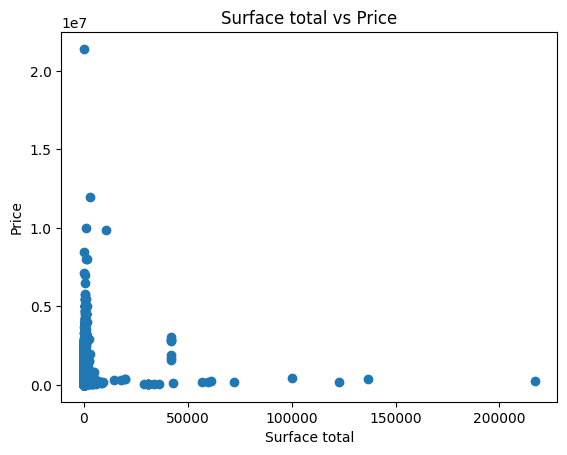

In [87]:
plt.scatter(mahal.property_surface_total,mahal.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [88]:
X = mahal[['property_surface_total','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_sfto_prc'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Casa,...,0.6745,0.969687,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.003556
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Departamento,...,0.0000,0.077161,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.184361
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Departamento,...,0.6745,0.969687,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.144626
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Departamento,...,0.6745,0.077161,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.056371
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,PH,...,0.6745,0.077161,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007135


In [89]:
np.sort(mahal.mahal_sfto_prc)

array([1.96278843e-06, 4.36770292e-06, 6.95097716e-06, ...,
       6.94618662e+03, 8.61290115e+03, 2.16314815e+04])

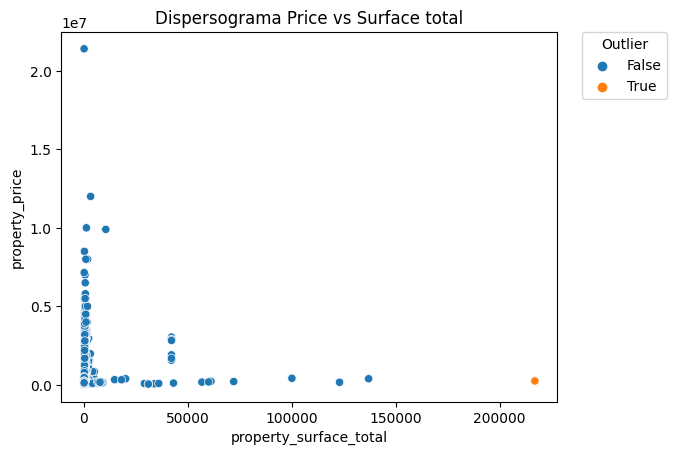

In [90]:
umbral=10000
mahal[mahal['mahal_sfto_prc']>umbral]

es_outlier = (mahal['mahal_sfto_prc'] > umbral)
sns.scatterplot(x=mahal.property_surface_total,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Price vs Surface total')
plt.show()

##### Caracteristicas

Podemos visualizar que los valores que se encuentran particularmente alejados de la masa de observaciones caben dentro de la clasificación de outliers globales.

#### Property rooms vs Property bedrooms

##### Scatter

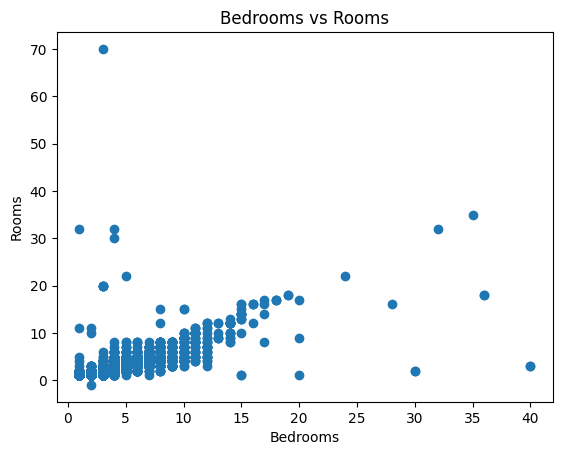

In [91]:
plt.scatter(mahal.property_rooms,mahal.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Mahalanobis

In [92]:
X = mahal[['property_rooms','property_bedrooms']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_bdro'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Casa,...,0.969687,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.003556,0.752562
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Departamento,...,0.077161,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.184361,0.013395
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Departamento,...,0.969687,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.144626,0.752562
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Departamento,...,0.077161,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.056371,1.391019
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,PH,...,0.077161,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007135,1.391019


In [93]:
np.sort(mahal.mahal_ro_bdro)

array([1.33948925e-02, 1.33948925e-02, 1.33948925e-02, ...,
       1.51997964e+03, 1.51997964e+03, 6.04251228e+03])

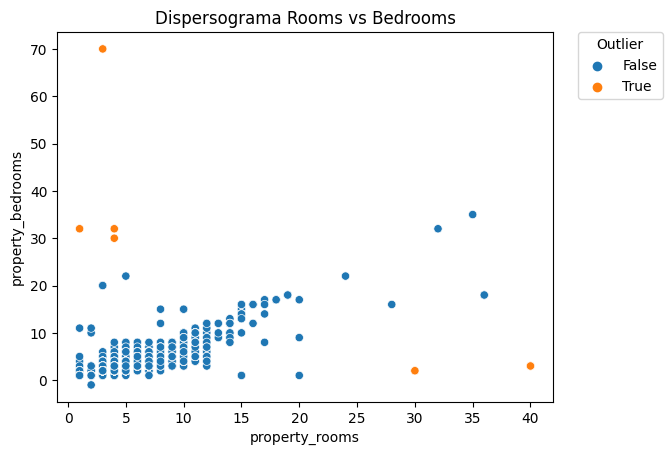

In [94]:
umbral=700
mahal[mahal['mahal_ro_bdro']>umbral]

es_outlier = (mahal['mahal_ro_bdro'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_bedrooms, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Bedrooms')
plt.show()

##### Caracteristicas

Notamos que estamos en presencia de outliers en su mayoría globales, con la particularidad de que tenemos algunos casos de valores atípicos colectivos en las cercanías del rango equivalente a 30 respecto del eje `property_bedrooms`.

Adicionalmente, cabe destacar que hay dos valores particularmente alejados. Siguiendo esta línea, llegamos a la conclusión de que estamos en presencia de outliers globales.

#### Property rooms vs Property surface total

##### Scatter


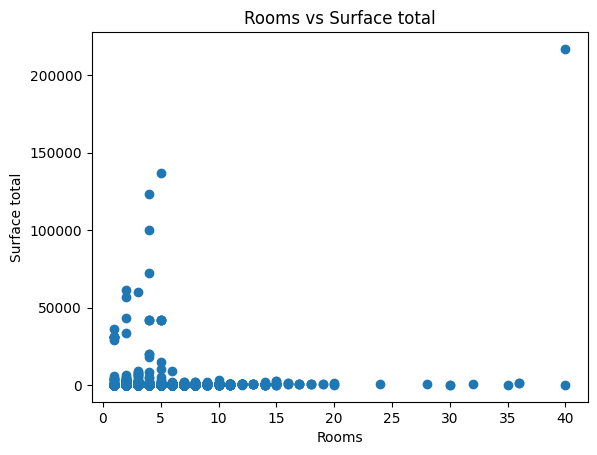

In [95]:
plt.scatter(mahal.property_rooms,mahal.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [96]:
X = mahal[['property_rooms','property_surface_total']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfto'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Casa,...,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.003556,0.752562,0.652342
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Departamento,...,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.184361,0.013395,0.014608
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Departamento,...,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.144626,0.752562,0.671945
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Departamento,...,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.056371,1.391019,0.664919
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,PH,...,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007135,1.391019,0.671308


In [97]:
np.sort(mahal.mahal_ro_sfto)

array([1.08831231e-02, 1.08831231e-02, 1.08832904e-02, ...,
       2.80830751e+03, 3.46664571e+03, 8.17657287e+03])

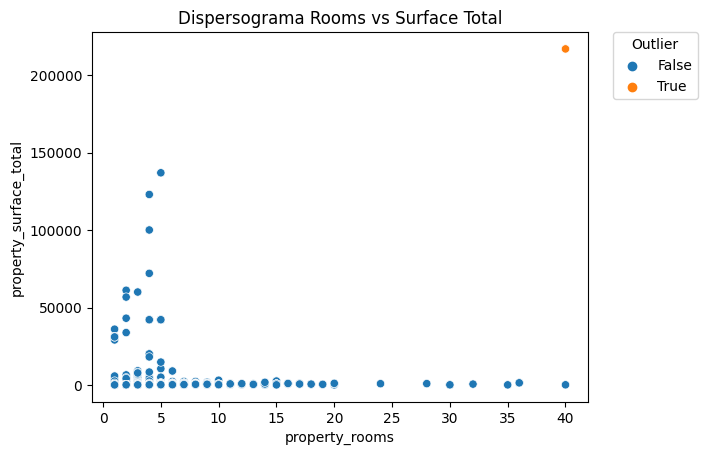

In [98]:
umbral=5000
mahal[mahal['mahal_ro_sfto']>umbral]

es_outlier = (mahal['mahal_ro_sfto'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_total, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Total')
plt.show()

##### Caracteristicas

En esta nueva comparación, contamos -una vez más- con la presencia de registros aislados en la parte superior izquierda que podríamos clasificarlos como outliers globales.

#### Property rooms vs Property surface covered

##### Scatter

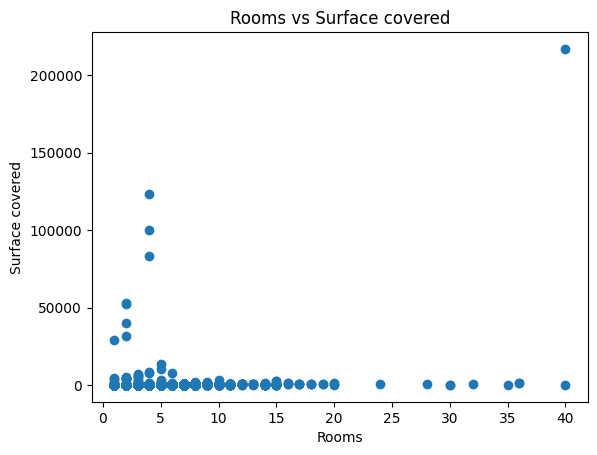

In [99]:
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Mahalanobis

In [100]:
X = mahal[['property_rooms','property_surface_covered']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfcv'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Casa,...,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.003556,0.752562,0.652342,0.647550
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Departamento,...,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.184361,0.013395,0.014608,0.016105
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Departamento,...,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.144626,0.752562,0.671945,0.658758
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Departamento,...,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.056371,1.391019,0.664919,0.649601
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,PH,...,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007135,1.391019,0.671308,0.657657


In [101]:
np.sort(mahal.mahal_ro_sfcv)

array([1.13880923e-02, 1.13880923e-02, 1.13880923e-02, ...,
       3.14784690e+04, 4.75979542e+04, 1.47185998e+05])

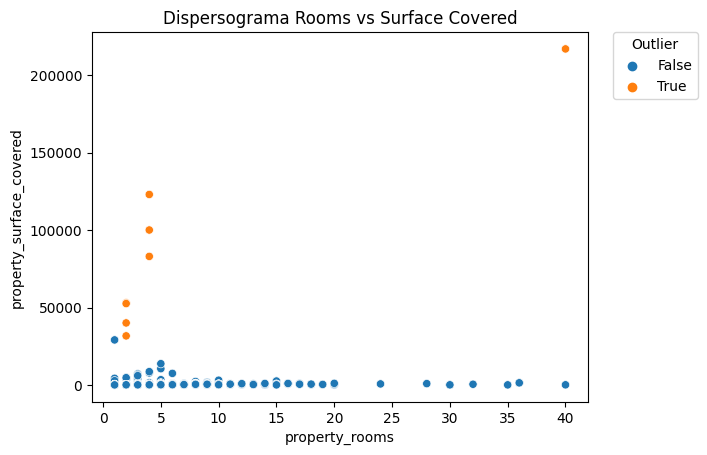

In [102]:
umbral=3000
mahal[mahal['mahal_ro_sfcv']>umbral]

es_outlier = (mahal['mahal_ro_sfcv'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_covered, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Covered')
plt.show()

##### Caracteristicas

Luego de la comparación de surface covered vs property rooms, notamos que nuevamente estamos en presencia de outliers, en particular esta vez todos de carácter global.


#### Property rooms vs Property price

##### Scatter

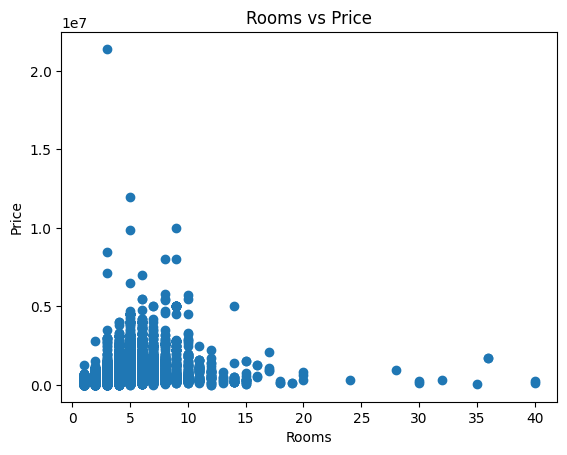

In [103]:
plt.scatter(mahal.property_rooms,mahal.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [104]:
X = mahal[['property_rooms','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_pr'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv,mahal_ro_pr
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Casa,...,0.768697,0.046016,2.529375,0.051091,2.85988,0.003556,0.752562,0.652342,0.647550,0.900695
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Departamento,...,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.184361,0.013395,0.014608,0.016105,0.357533
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Departamento,...,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.144626,0.752562,0.671945,0.658758,1.468295
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Departamento,...,0.024422,0.016226,1.551350,-0.005307,1.05222,0.056371,1.391019,0.664919,0.649601,1.188326
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,PH,...,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007135,1.391019,0.671308,0.657657,0.775737


In [105]:
np.sort(mahal.mahal_ro_pr)

array([1.37892392e-02, 1.37894774e-02, 1.37894774e-02, ...,
       1.17821145e+03, 1.75912533e+03, 5.89704763e+03])

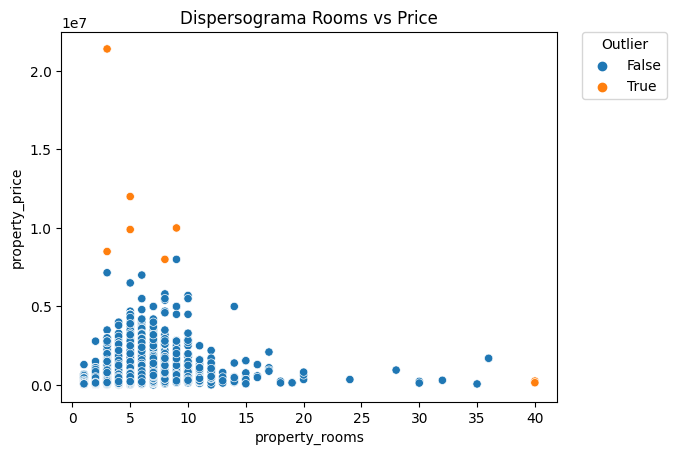

In [106]:
umbral=700
mahal[mahal['mahal_ro_pr']>umbral]

es_outlier = (mahal['mahal_ro_pr'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Price')
plt.show()

##### Caracteristicas

Nuevamente visualizamos outliers globales.

### Tratamiento

Para cada una de las variables, estudiamos si es posible eliminar los valores atípicos encontrados con los métodos previamente descriptos analizando la proporción que estos representan sobre el total de los valores, teniendo en cuenta la decisión de admitir una tolerancia del 10% de otuliers.

#### Property rooms

In [107]:
rooms_outliers_porcentaje = df[(df['zm_rooms']>3.5)].shape[0]/df['zm_rooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_rooms representan un {round(rooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_rooms representan un 0.43% del total del dataset.


Eliminamos los outliers del dataset:

In [108]:
df.drop(df[df['zm_rooms']>3.5].index, inplace=True)

#### Property bedrooms

In [109]:
bedrooms_outliers_porcentaje = df[(df['zm_bedrooms']>3.5)].shape[0]/df['zm_bedrooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_bedrooms representan un {round(bedrooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_bedrooms representan un 0.033% del total del dataset.


In [110]:
df.drop(df[df['zm_bedrooms']>3.5].index, inplace=True)

#### Property price

In [111]:
price_outliers_porcentaje = df[(df['zm_price']>3.5)].shape[0]/df['zm_price'].shape[0]*100

print(f"Los valores atípicos encontrados para property_price representan un {round(price_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_price representan un 8.911% del total del dataset.


In [112]:
df.drop(df[df['zm_price']>3.5].index, inplace=True)

#### Property surface covered

In [113]:
surface_covered_outliers_porcentaje = df[(df['zm_surface_covered']>3.5)].shape[0]/df['zm_surface_covered'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_covered representan un {round(surface_covered_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_covered representan un 2.723% del total del dataset.


In [114]:
df.drop(df[df['zm_surface_covered']>3.5].index, inplace=True)

#### Property surface total

In [115]:
surface_total_outliers_porcentaje = df[(df['zm_surface_total']>3.5)].shape[0]/df['zm_surface_total'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_total representan un {round(surface_total_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_total representan un 1.442% del total del dataset.


In [116]:
df.drop(df[df['zm_surface_total']>3.5].index, inplace=True)

## **1d. Reducción de la dimensionalidad**

Para realizar la reducción de la dimensionalidad del dataset, estaremos utilizando el algoritmo PCA con el objetivo de reducir la dimensión del problema descartando la información redundante existente.

Generamos un nuevo dataset de reducción de dimensionalidad:

In [117]:
df_reduc = df.copy()

Antes de ejecutar el algoritmo, verificamos que no existan nulos para las variables de importancia que no brinden información de relevancia. En caso de existir, los eliminamos.

In [118]:
df_reduc.drop(df_reduc[df_reduc['property_rooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_bedrooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_price'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_covered'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_total'].isna()].index, inplace=True)

In [119]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_price', 'property_surface_covered', 'property_surface_total']

x = df_reduc.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

In [120]:
pca = PCA(n_components=5)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4','cp_5'])

In [121]:
df_reduc['target'] = 0
target = pd.DataFrame((np.column_stack(df_reduc['target'])).tolist()).T
df_pca = pd.concat([pca_df_aux, target], axis = 1)
df_pca.columns= ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5','target']
df_pca.head()

,cp_1,cp_2,cp_3,cp_4,cp_5,target
0,4.317567,0.026814,-1.732306,0.230546,0.055048,0
1,-0.171776,1.056410,-0.032921,-0.065933,-0.069353,0
2,1.303632,1.819293,0.223940,0.121763,-0.108596,0
3,2.034962,0.461844,-0.889194,-0.648366,-0.543555,0
4,1.587061,-0.125995,0.846898,-0.714490,-0.124547,0


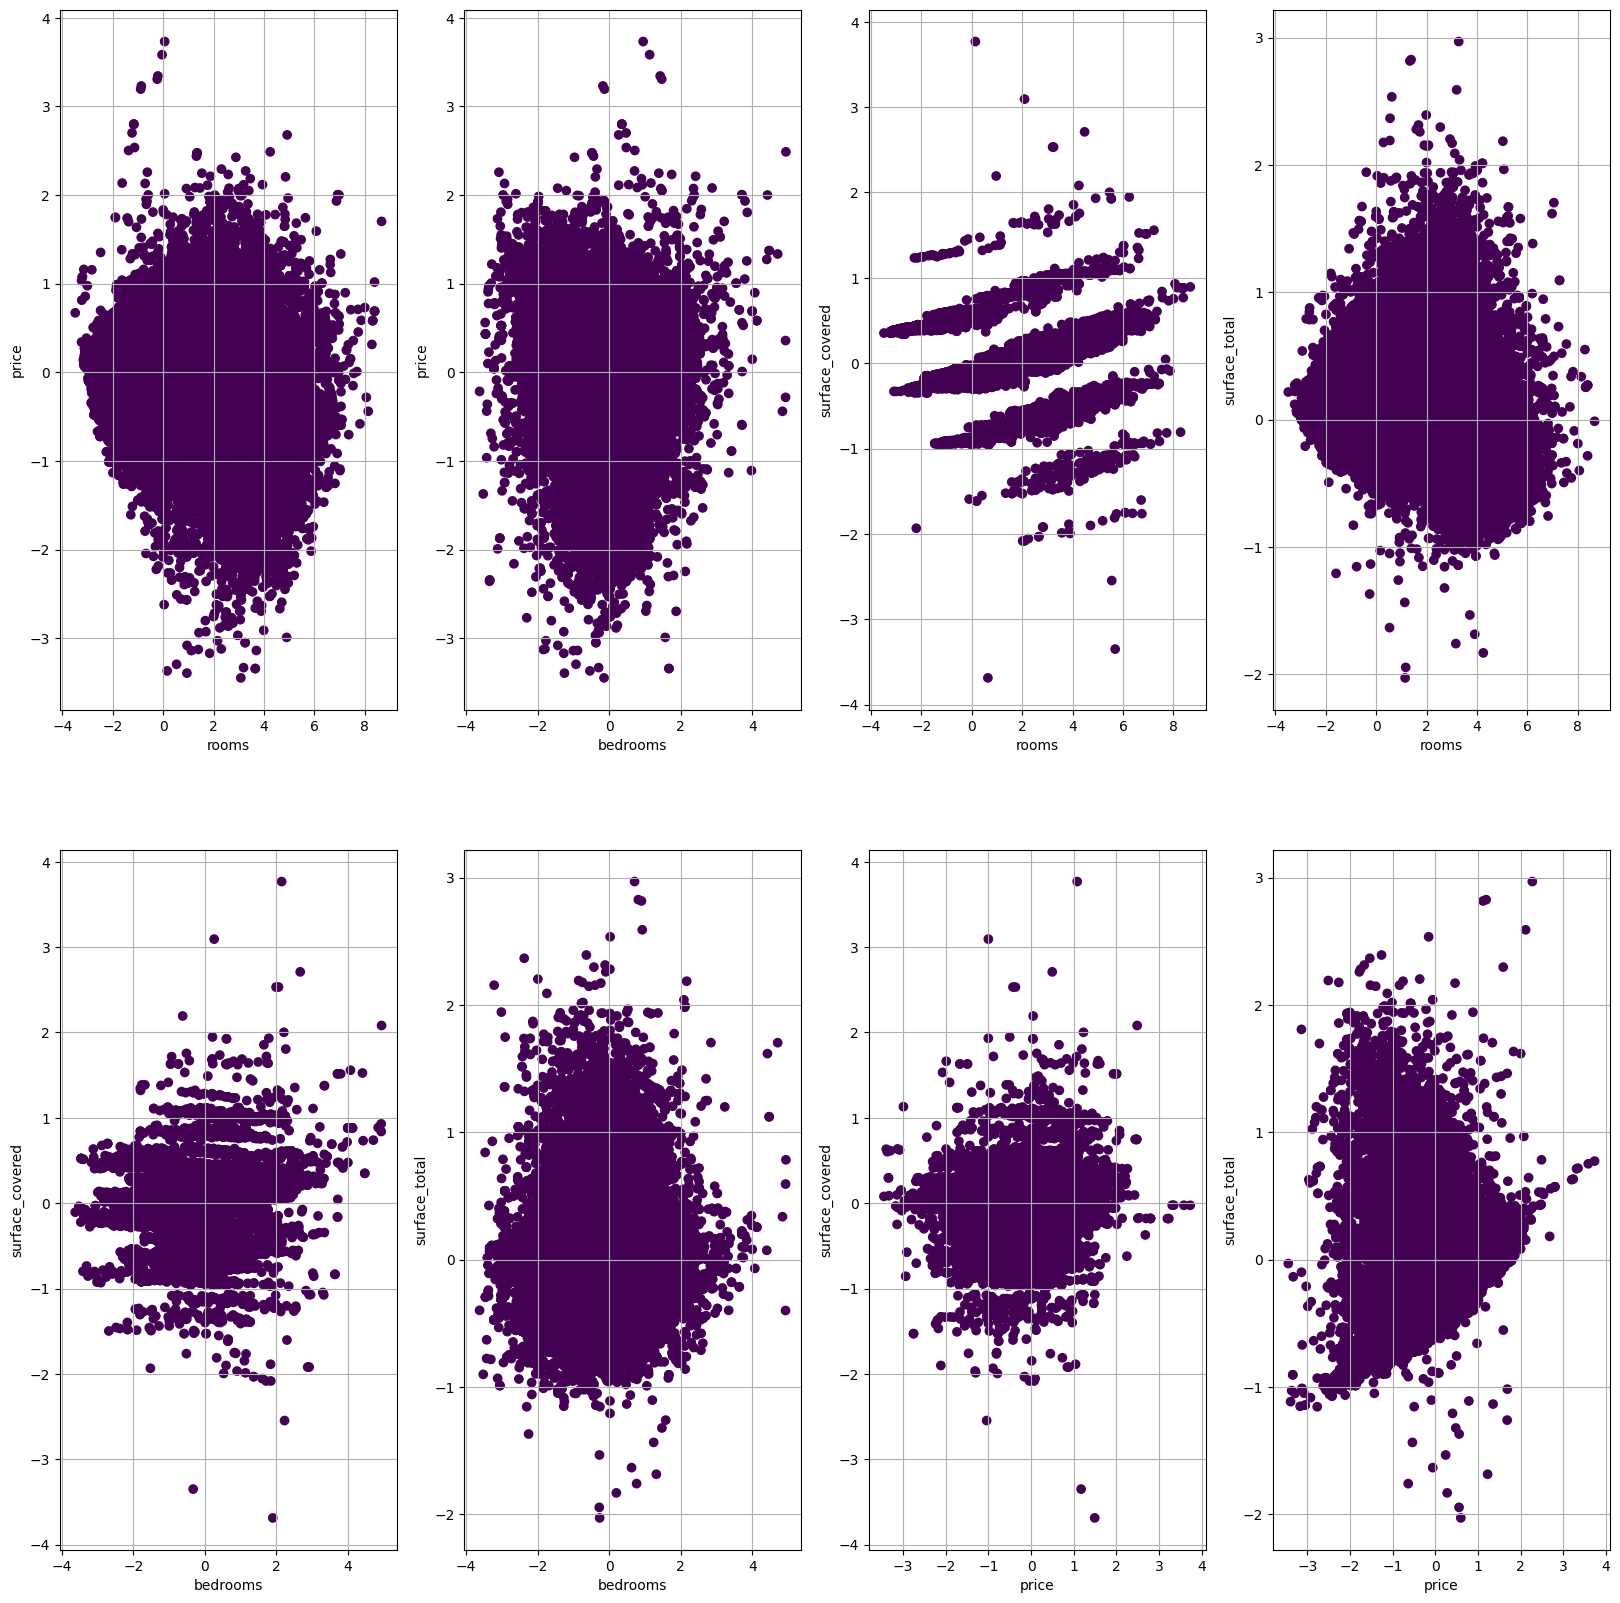

In [122]:
targets = ['Casa', 'PH', 'Departamento']

fig = plt.figure(figsize = (20,20))

c = df_pca['target']

## plot 1

ax = fig.add_subplot(2, 4, 1) 

x = df_pca['cp_1']
y = df_pca['cp_3']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('price', fontsize = 10)
ax.grid()

## plot 2

ax = fig.add_subplot(2, 4, 2) 

x = df_pca['cp_2']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('price', fontsize = 10)
ax.grid()

## plot 3

ax = fig.add_subplot(2, 4, 3) 

x = df_pca['cp_1']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 4

ax = fig.add_subplot(2, 4, 4) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

## plot 5

ax = fig.add_subplot(2, 4, 5) 

x = df_pca['cp_2']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 6

ax = fig.add_subplot(2, 4, 6) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

## plot 7

ax = fig.add_subplot(2, 4, 7) 

x = df_pca['cp_3']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('price', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 8

ax = fig.add_subplot(2, 4, 8) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('price', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

plt.show()

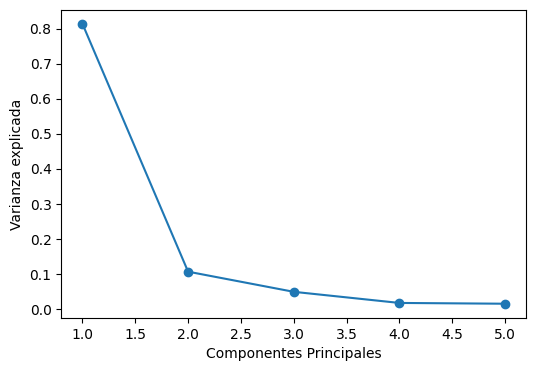

In [123]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada, '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

#  **2. Agrupamiento**

Primero removemos entradas del dataframe que contienen coordenadas fuera de CABA



In [124]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

CABA_lat = -34.611817
CABA_long = -58.446881

df = df.loc[((CABA_lat - 0.5) < df["latitud"]) & (df["latitud"] < (CABA_lat + 0.5))]
df = df.loc[((CABA_long - 0.5) < df["longitud"]) & (df["longitud"] < (CABA_long + 0.5))]

El primer análisis de clustering lo realizamos entre las variables longitud y latitud, viendo la tendencia al agrupamiento que existe en la posición geográfica:



In [125]:
X = np.column_stack((df.longitud.tolist(), df.latitud.tolist()))

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 

KeyboardInterrupt



Utilizando 5 clusters



In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()
print ("Silhouette Score para 5 clusters = " + str(silhouette_score(X, y_kmeans)))

Utilizando 3 clusters



In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()

print ("Silhouette Score para 3 clusters = " + str(silhouette_score(X, y_kmeans)))

Viendo la curva de cantidad de clusters contra la distancia media al centroide (SSE) podemos ver que no existen clusters definidos, no se ve un claro codo en el cual elegir un numero de clusters ideal. No existen agrupamientos definidos.

Un segundo análisis que decidimos realizar es si existe clustering entre tres variables: longitud, latitud y precio. Obtuvimos los mismos resultados que el caso anterior:

In [ ]:
X = df.iloc[:,[5,4,15]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

centers = kmeans.cluster_centers_
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=0.2)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c="red", s=500, marker="o")

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=1)


Como no obtuvimos un clustering definido, buscamos ver si existía un agrupamiento entre ubicación geográfica y precio por metro cuadrado. Los resultados fueron similares.

In [ ]:
df["property_m2price"] = df["property_price"] / df["property_surface_total"]
X = df.iloc[:,[5,4, df.shape[1]-1]].loc[(df.property_m2price < 5000)].values
sse = []
sscore = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    y_kmeans = km.predict(X)
    sse.append(km.inertia_)
    sscore.append(silhouette_score(X, y_kmeans))
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=5)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)


In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sscore, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
X = df.iloc[:,[15,13]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

In [ ]:
X = df.iloc[:,[11,14]].loc[df.property_rooms.notna()].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
   km = KMeans(n_clusters=k)
   km.fit(X)
   sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

#  **3. Clasificación**

## **3a. Construcción del target**

Primera alternativa, variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [126]:
df["property_m2price"] = df["property_price"] / df["property_surface_total"]
df.sort_values(by=["property_m2price"], inplace=True)

In [127]:
df['tipo_precio_1'] = pd.qcut(x=df['property_m2price'], q=3, labels=['bajo', 'medio', 'alto'])
df.value_counts("tipo_precio_1")

tipo_precio_1
bajo     27259
alto     27221
medio    27220
dtype: int64

In [128]:
df['tipo_precio_2'] = pd.qcut(x=df['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto'])
df['tipo_precio_2'].replace("medio2","medio", inplace=True)
df.value_counts("tipo_precio_2")

tipo_precio_2
medio    40847
bajo     20431
alto     20422
dtype: int64

Quitamos los outliers mayores a 8000 porque arruinan el gráfico. Revisar mahalanovis.

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,property_type,...,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,property_m2price,tipo_precio_1,tipo_precio_2
140460,u8oPwCg2R/C105SlZ9nlaQ==,2021-12-08,2022-01-27,2021-12-08,-34.579756,-58.406144,Capital Federal,Palermo,Palermo,Departamento,...,0.0000,-0.686557,-1.586238,0.022390,1.753700,0.008161,1.48390,62.500000,bajo,bajo
85413,RZ744+VZFnLS5FWxmtTJ7A==,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,Capital Federal,Palermo,Palermo,Departamento,...,0.6745,-0.675223,-1.544244,0.069643,3.305050,0.046040,2.69800,67.339394,bajo,bajo
85414,NbzjXoT+aeAnxr2lTv1Whw==,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,Capital Federal,Palermo,Palermo,Departamento,...,0.6745,-0.675223,-1.544244,0.069643,3.305050,0.046040,2.69800,67.339394,bajo,bajo
85401,C1aQamphkTF6eZWtt2ELFw==,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,Capital Federal,Palermo,Palermo,Departamento,...,0.6745,-0.675223,-1.544244,0.049098,2.630550,0.029205,2.15840,76.627586,bajo,bajo
79676,5lBJkaOpRzdbcOFuJ59/4A==,2021-08-17,2022-01-27,2021-08-17,-34.647545,-58.497062,Capital Federal,Mataderos,Mataderos,PH,...,0.6745,-0.675223,-1.544244,-0.003292,0.910575,0.018262,1.80766,84.174242,bajo,bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54064,GJj+efEGbZg/aHjkurBiUw==,2021-09-22,2021-10-27,2021-09-22,-34.617660,-58.362977,Capital Federal,Puerto Madero,Puerto Madero,Departamento,...,-0.6745,0.435534,2.571241,-0.041300,-0.337250,-0.052445,-0.45866,7604.166667,alto,alto
168525,z0BCvLPp4py4luBcysV3yg==,2021-04-30,2021-05-28,2021-04-30,-34.617978,-58.362848,Capital Federal,Puerto Madero,Puerto Madero,Departamento,...,-0.6745,0.294291,2.047922,-0.053627,-0.741950,-0.057496,-0.62054,7619.047619,alto,alto
459364,9JgJiB0/l+tDl+vIdXdGaQ==,2021-01-05,2021-04-20,2021-01-05,-34.569453,-58.433300,Capital Federal,Palermo,Palermo,Departamento,...,0.0000,0.137356,1.466456,-0.024864,0.202350,-0.063388,-0.80940,7714.285714,alto,alto
190609,/MC0i98hQuKwdP9/I6NdRg==,2021-10-09,2022-01-27,2021-10-09,-34.568710,-58.473026,Capital Federal,Saavedra,Saavedra,Departamento,...,-0.6745,-0.367980,-0.405875,-0.064926,-1.112925,-0.081065,-1.37598,7785.642857,alto,alto


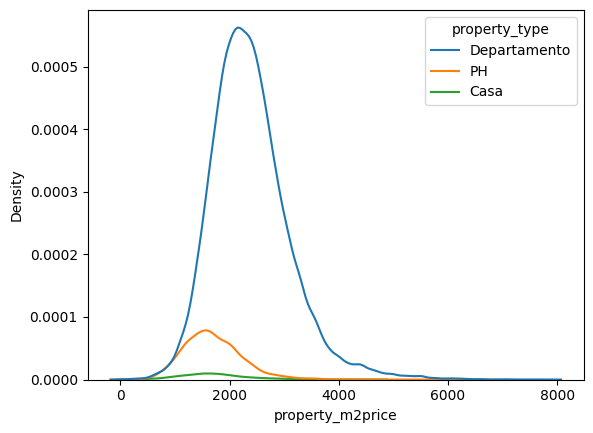

In [129]:
sns.kdeplot(data=df.loc[df['property_m2price'] < 8000], x = 'property_m2price', hue='property_type')
df.loc[df['property_m2price'] < 8000]

<AxesSubplot: xlabel='property_m2price', ylabel='Density'>

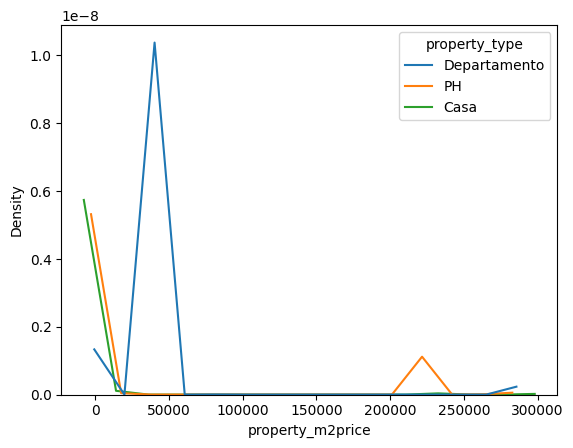

In [130]:
sns.kdeplot(data=df, x="property_m2price", hue="property_type", gridsize=15)

<AxesSubplot: >

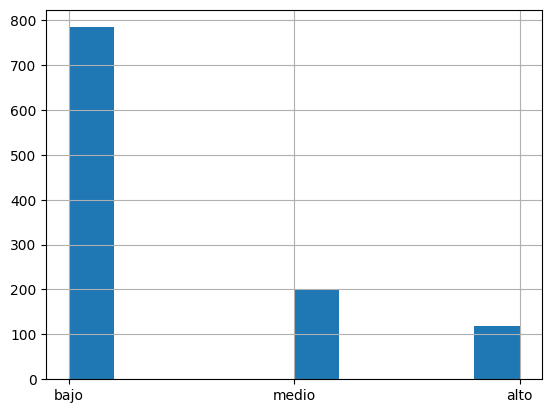

In [131]:
df.loc[df['property_type'].isin(["Casa"])]['tipo_precio_1'].hist()

<AxesSubplot: >

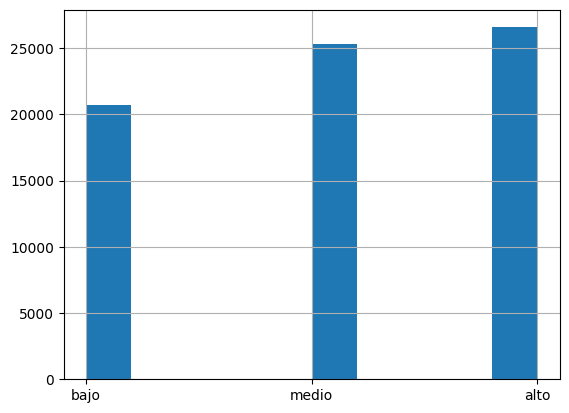

In [132]:
df.loc[df['property_type'].isin(["Departamento"])]['tipo_precio_1'].hist()

<AxesSubplot: >

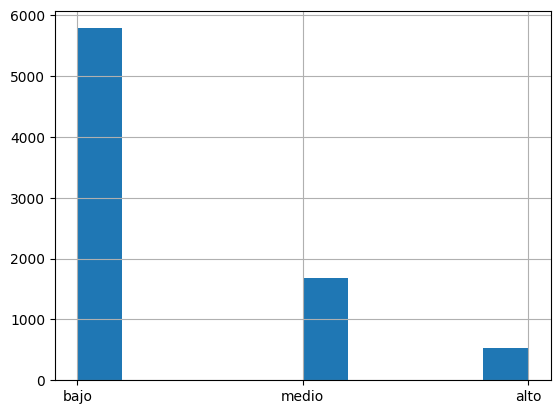

In [133]:
df.loc[df['property_type'].isin(["PH"])]['tipo_precio_1'].hist()

De analizar el gráfico resultante para el tipo de precio de las propiedades de tipo "PH" podemos ver que la mayor cantidad de publicaciones (aproximadamente 3000) tienen un precio alto en comparación con las demás. Adicionalmente podemos ver que hay cerca de unas 2500 publicaciones con precios bajo y medio.

## **3b. Entrenamiento y Predicción**

Primero creamos un dataset sin los features a predecir

In [134]:
ds_trabajo_x=df.drop(['tipo_precio_1', 'tipo_precio_2', 'z_price', 'zm_price', 'place_l2', 'place_l3', 'property_price', 'id', 'property_m2price','z_rooms','zm_rooms','z_bedrooms','zm_bedrooms','z_surface_covered','zm_surface_covered','z_surface_total',
'zm_surface_total'], axis='columns')
ds_trabajo_x.dtypes

start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
place_l4                            object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
dtype: object

Realizamos one hot encoding para las variables cualitativas

In [135]:
ds_trabajo_x = pd.get_dummies(ds_trabajo_x, columns=['place_l4', 'property_type'], drop_first=True)
ds_trabajo_x.head()

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,place_l4_Agronomía,...,place_l4_Villa Ortuzar,place_l4_Villa Pueyrredón,place_l4_Villa Real,place_l4_Villa Riachuelo,place_l4_Villa Santa Rita,place_l4_Villa Soldati,place_l4_Villa Urquiza,place_l4_Villa del Parque,property_type_Departamento,property_type_PH
140460,2021-12-08,2022-01-27,2021-12-08,-34.579756,-58.406144,3.0,2.0,120.0,110.0,0,...,0,0,0,0,0,0,0,0,1,0
85413,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,4.0,3.0,165.0,156.0,0,...,0,0,0,0,0,0,0,0,1,0
85414,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,4.0,3.0,165.0,156.0,0,...,0,0,0,0,0,0,0,0,1,0
85401,2021-03-26,2021-11-03,2021-03-26,-34.569770,-58.431032,4.0,3.0,145.0,136.0,0,...,0,0,0,0,0,0,0,0,1,0
79676,2021-08-17,2022-01-27,2021-08-17,-34.647545,-58.497062,5.0,3.0,132.0,85.0,0,...,0,0,0,0,0,0,0,0,0,1


Reemplazamos las fechas por valores numéricos

In [136]:
import math
import sys
max_end_date = max(ds_trabajo_x['end_date'])
ds_trabajo_x['start_date'] = ds_trabajo_x['start_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else max(df['start_date']))
ds_trabajo_x['end_date'] = ds_trabajo_x['end_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else max_end_date.toordinal())
ds_trabajo_x['created_on'] = ds_trabajo_x['created_on'].apply(lambda x: x.toordinal() if not pd.isna(x) else max(df['created_on']))
ds_trabajo_x.dtypes

start_date                      int64
end_date                        int64
created_on                      int64
latitud                       float64
longitud                      float64
                               ...   
place_l4_Villa Soldati          uint8
place_l4_Villa Urquiza          uint8
place_l4_Villa del Parque       uint8
property_type_Departamento      uint8
property_type_PH                uint8
Length: 72, dtype: object

Luego creamos un dataset con la variable target

In [190]:
ds_trabajo_y = df['tipo_precio_1'].copy()

Separamos en conjuntos de test y train

In [191]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,
                                                    random_state=100)

## Modelo 1: Arbol de Decisión

In [192]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [*range(18, 23, 1)],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00003,0.00004,0.00005, 0.00006,0.00007]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [3e-05, 4e-05, 5e-05, 6e-05, 7e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [18, 19, 20, 21, 22]})

In [193]:
grid.best_params_

{'ccp_alpha': 4e-05, 'criterion': 'gini', 'max_depth': 21}

In [194]:
grid.score(x_train, y_train)

0.76468788249694

In [195]:
y_pred = grid.predict(x_test)

In [196]:
pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

,test,pred
0,medio,alto
1,bajo,alto
2,medio,medio
3,alto,alto
4,medio,alto
...,...,...
16335,alto,alto
16336,bajo,medio
16337,alto,medio
16338,medio,bajo


Podemos ver los resultados con una matriz de confusión.
Orden: Alto, Bajo, Medio

Text(50.722222222222214, 0.5, 'True')

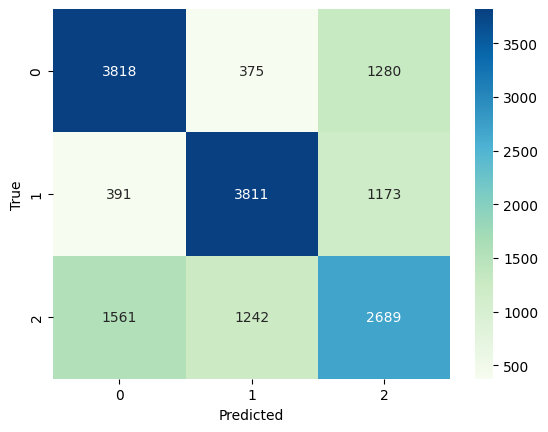

In [197]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

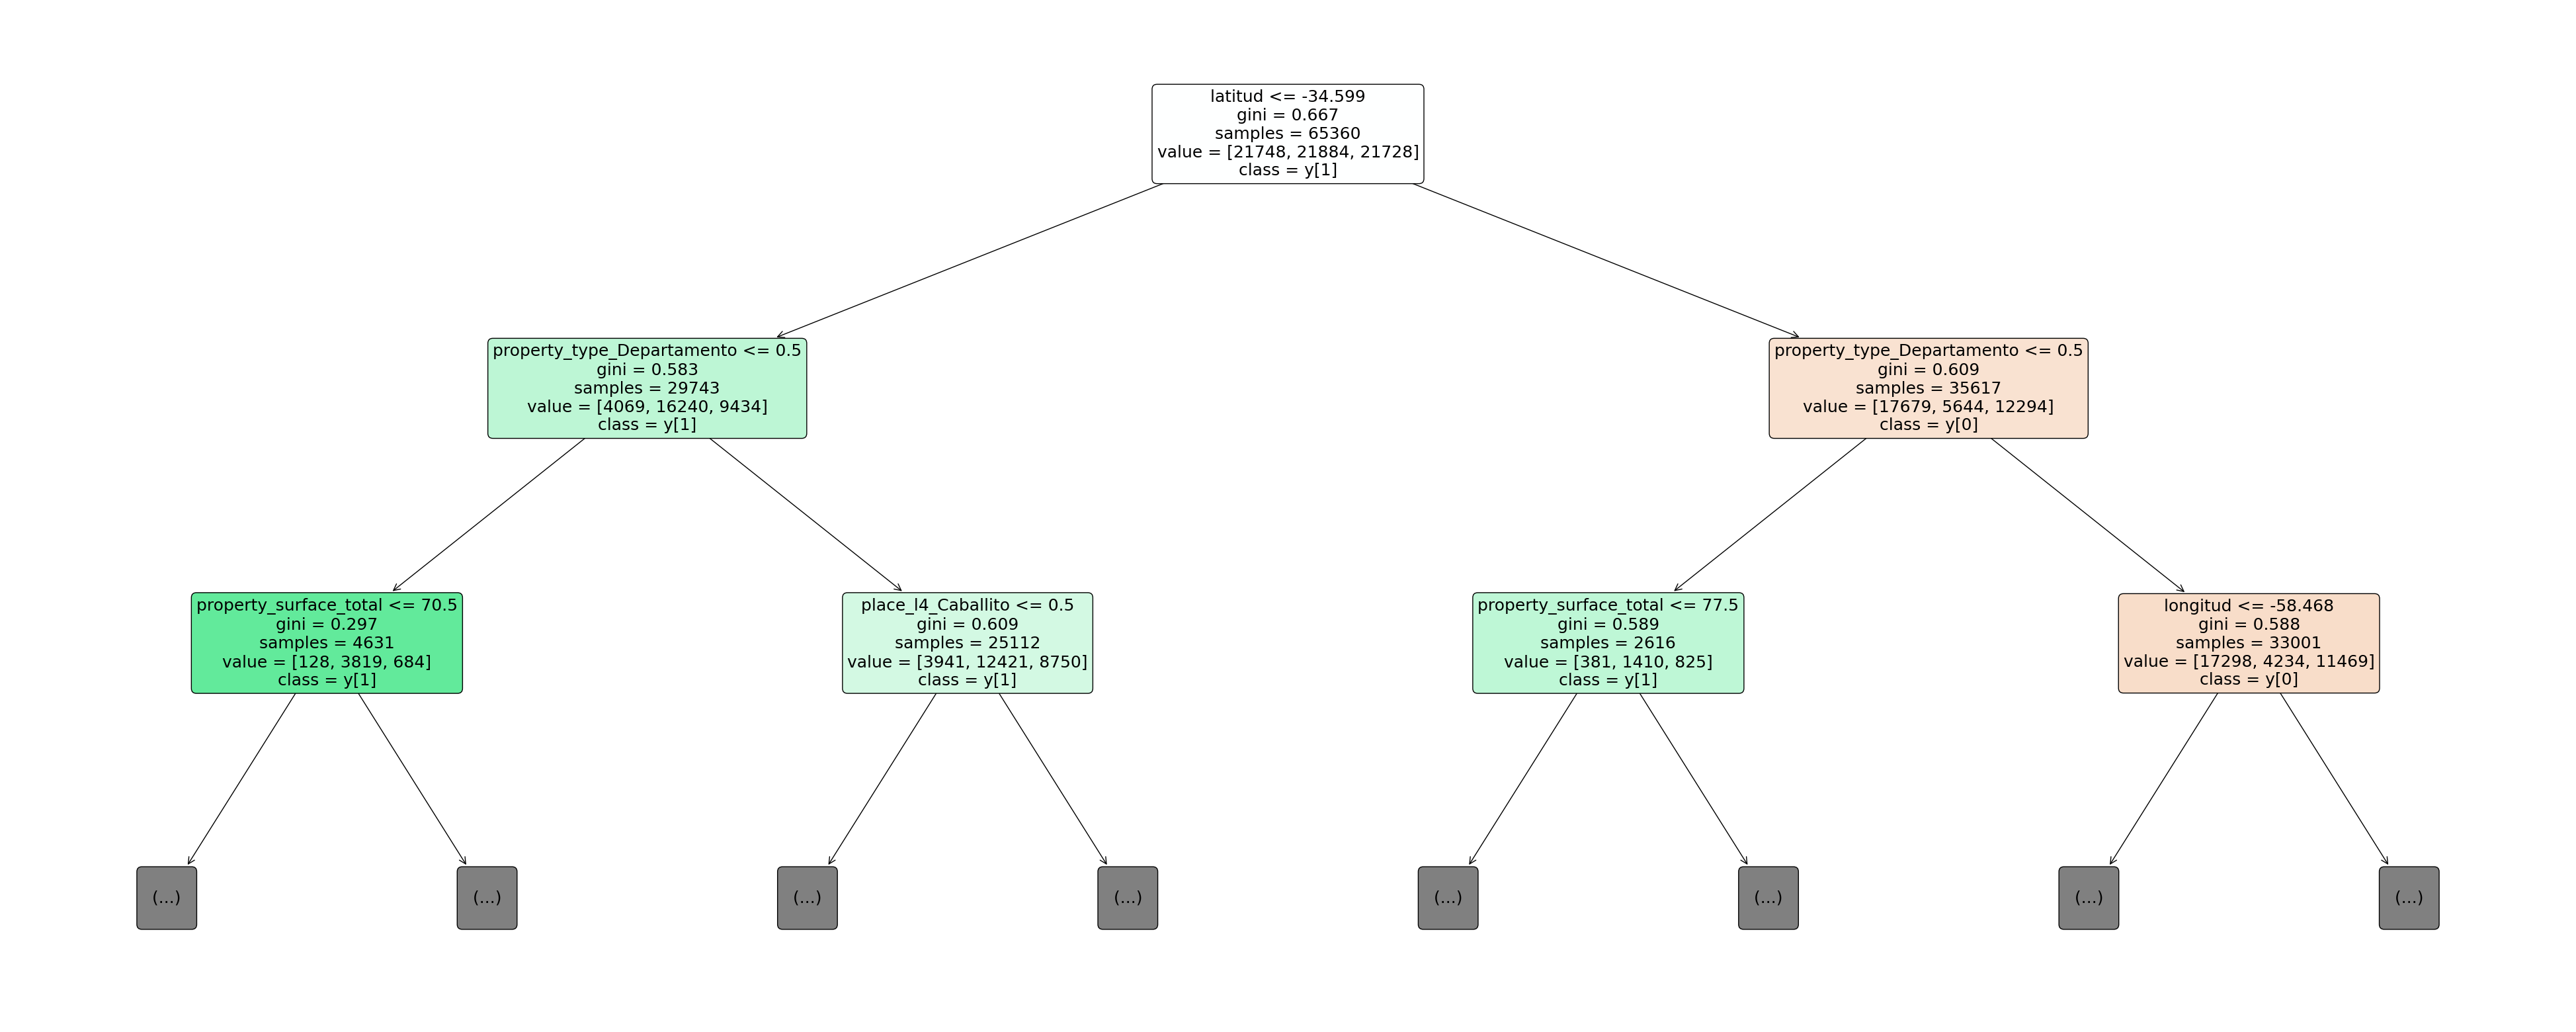

In [198]:
plt.figure(figsize=(50,20))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [ ]:
grid.score(x_test, y_test)

Utilizando el segunto tipo de target anteriormente calculado

In [199]:
ds_trabajo_y = df['tipo_precio_2'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,
                                                    random_state=100)

In [200]:
param_grid = {
    'max_depth': [*range(18, 23, 1)],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00003,0.00004,0.00005, 0.00006,0.00007]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [3e-05, 4e-05, 5e-05, 6e-05, 7e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [18, 19, 20, 21, 22]})

In [201]:
grid.best_params_

{'ccp_alpha': 6e-05, 'criterion': 'gini', 'max_depth': 22}

In [202]:
grid.score(x_train, y_train)

0.7189259485924112

In [203]:
y_pred = grid.predict(x_test)

In [204]:
pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

,test,pred
0,medio,alto
1,bajo,alto
2,medio,medio
3,alto,alto
4,medio,alto
...,...,...
16335,alto,alto
16336,bajo,medio
16337,alto,medio
16338,medio,medio


Text(50.722222222222214, 0.5, 'True')

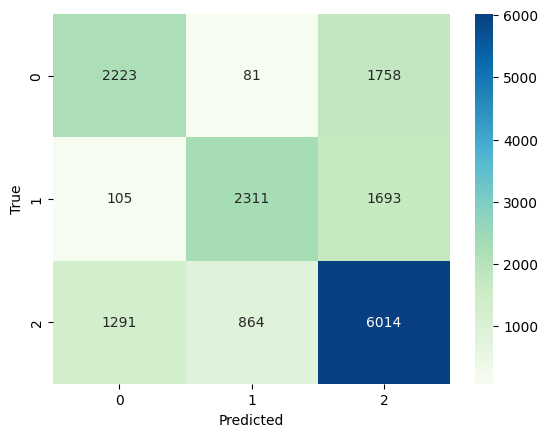

In [205]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

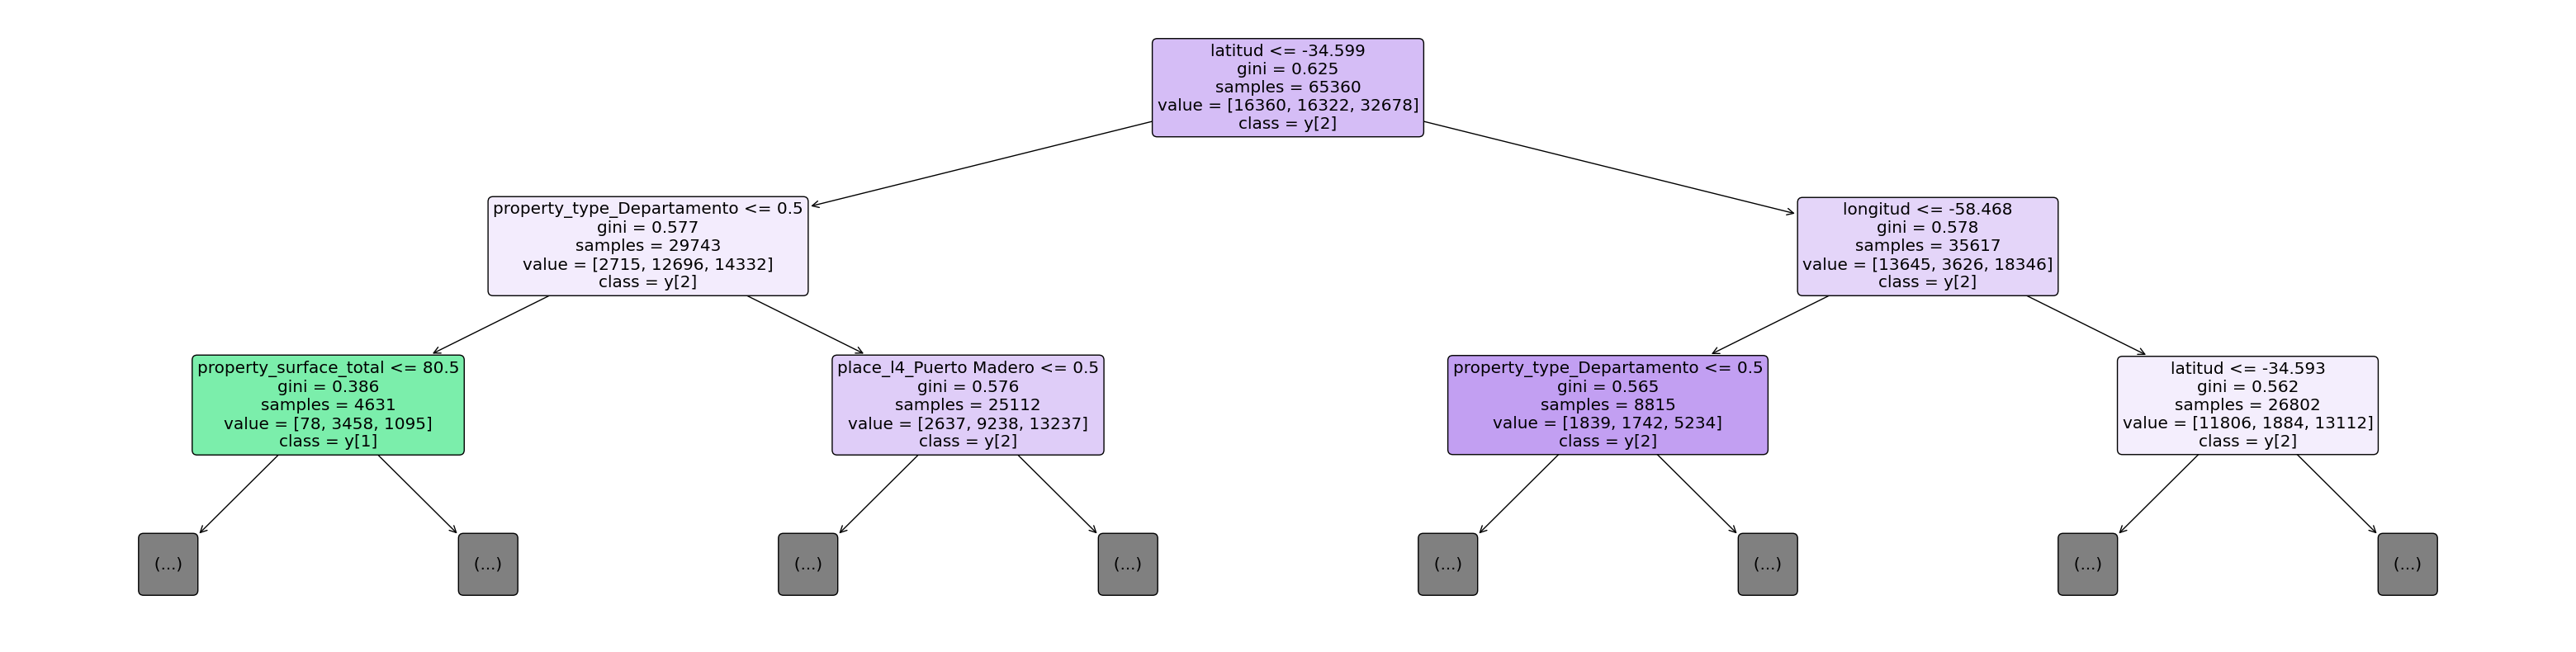

In [206]:
plt.figure(figsize=(40,10))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [207]:
grid.score(x_test, y_test)

0.6455324357405141

## Modelo 2: Random Forest

In [231]:
ds_trabajo_y = df['tipo_precio_1'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,
                                                    random_state=100)

In [232]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [40, 55],
    'max_depth': [23, 25],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00002,0.000025]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [2e-05, 2.5e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [23, 25], 'n_estimators': [40, 55]})

In [233]:
grid.best_params_

{'ccp_alpha': 2e-05,
 'criterion': 'entropy',
 'max_depth': 25,
 'n_estimators': 55}

In [234]:
grid.score(x_train, y_train)

0.949250305997552

In [235]:
y_pred = grid.predict(x_test)

pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

,test,pred
0,medio,alto
1,bajo,bajo
2,medio,alto
3,alto,alto
4,medio,alto
...,...,...
16335,alto,alto
16336,bajo,medio
16337,alto,medio
16338,medio,bajo


Podemos ver los resultados con una matriz de confusión.
Orden: Alto, Bajo, Medio

Text(50.722222222222214, 0.5, 'True')

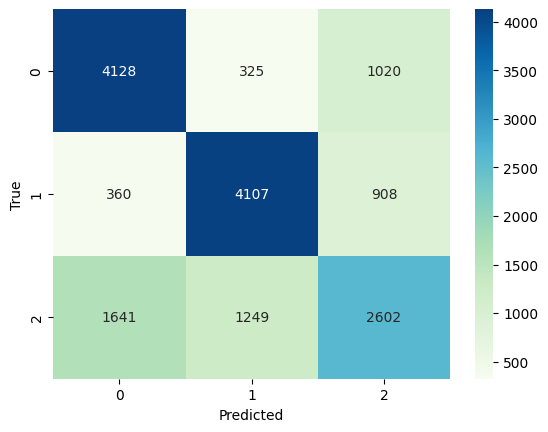

In [236]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [238]:
grid.score(x_test, y_test)

0.663219094247246

## Método 3: KNN

In [247]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [*range(3, 8, 1)],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_jobs':[-1],
    'leaf_size':[*range(15, 27, 2)]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [15, 17, 19, 21, 23, 25], 'n_jobs': [-1],
                         'n_neighbors': [3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']})

In [248]:
grid.best_params_

{'algorithm': 'kd_tree',
 'leaf_size': 15,
 'n_jobs': -1,
 'n_neighbors': 6,
 'weights': 'distance'}

In [249]:
grid.score(x_train, y_train)

0.9954406364749082

In [250]:
y_pred = grid.predict(x_test)

pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

,test,pred
0,medio,alto
1,bajo,bajo
2,medio,medio
3,alto,alto
4,medio,medio
...,...,...
16335,alto,alto
16336,bajo,alto
16337,alto,bajo
16338,medio,medio


Text(50.722222222222214, 0.5, 'True')

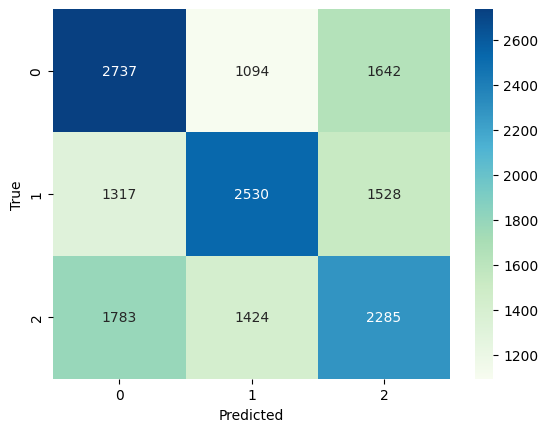

In [251]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [252]:
grid.score(x_test, y_test)

0.46217870257037946

#  **4. Regresión**

#  **5. Conclusiones**